This notebook generates cluster maps of the Cucomungo Canyon alluvial fan in Death Valley, CA.

Citation:

*Jacob Adler, Frances Rivera-Hernández, and Hannah Kerner (2024). K-means Cluster Mapping to Aid Field Exploration of Uncharted Sites. manuscript under review*

Zenodo repository: https://doi.org/10.5281/zenodo.12537954

Google Drive shared_url = 'https://drive.google.com/drive/folders/1rE596k3NcCNeewb0p2ANcrKTNU0cfdRs?usp=sharing'

Github: https://github.com/jba6/cucomungo-clustering

To run successfully, you must create a results folder and link to input files as described in the cells below.

# Load Datasets

In [1]:
# Set path of Results folder in Colab
# Then add a folder with the same name to colab (on left tab under files, right click -> add new folder)
results = '/content/Results_6_25_24/'

In [2]:
# install packages
!pip install rasterio==1.4a2

In [3]:
# import packages
%matplotlib inline
from google.colab import files
import rasterio
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sklearn
import gc
import seaborn as sns
sns.set()
import pandas as pd
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA;
from sklearn.decomposition import FastICA;
from rasterio.transform import from_origin
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from matplotlib.pyplot import imshow
from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde
from scipy import linalg
from itertools import combinations
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.feature import greycomatrix, greycoprops
from skimage import data, segmentation, color
from skimage.future import graph
plt.style.use('default')

In [4]:
# Download the folder of the latest copy of input files from either of the links below:
# Zenodo repository: https://doi.org/10.5281/zenodo.12537954
# or shared_url = 'https://drive.google.com/drive/folders/1rE596k3NcCNeewb0p2ANcrKTNU0cfdRs?usp=sharing'

# Then upload the files to a new folder on your own Google Drive

# Mount your Google Drive content and give it permission
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# Lists all .tif files in your Google Drive folder
import os
def myfunction(data):
  print(data)

path1 = 'drive/MyDrive/Cucomungo_Datasets_Colab/full_fan_datasets/'

for file in os.listdir(path1):
  if file.endswith(".tif"):
    myfunction(file)

clay_fan.tif
carb_fan.tif
ti_fan.tif
iron_fan.tif


In [6]:
# Open raster files full fan
iron_fan = rasterio.open(path1+'iron_fan.tif');
clay_fan = rasterio.open(path1+'clay_fan.tif');
carb_fan = rasterio.open(path1+'carb_fan.tif');
ti_fan = rasterio.open(path1+'ti_fan.tif');

# Create arrays
iron_fan_arr = iron_fan.read([1]);
clay_fan_arr = clay_fan.read([1]);
carb_fan_arr = carb_fan.read([1]);
ti_fan_arr = ti_fan.read([1]);

# Combine bands into one dataset
combined_fan = np.concatenate([iron_fan_arr,
                           clay_fan_arr,
                           carb_fan_arr,
                           ti_fan_arr]);
combined_fan = np.moveaxis(combined_fan, 0, 2);

In [7]:
combined_fan.shape

(570, 318, 4)

# Flatten and Clean Data

In [8]:
# Create datasets full fan and flatten
data4b_fan = combined_fan[...,[0,1,2,3]];
data4bf_fan = np.reshape(data4b_fan, [data4b_fan.shape[0]*data4b_fan.shape[1], data4b_fan.shape[2]]);

In [9]:
# Get list of good data indices since negative values are no data
data_inds4_fan = list(set(np.where(np.all(data4bf_fan > 0, axis=1))[0]));

In [10]:
len(data_inds4_fan)

123609

In [11]:
data4bf_fan[120,0]

-3.4028235e+38

In [12]:
data4bf_fan[data_inds4_fan].min()

0.995509

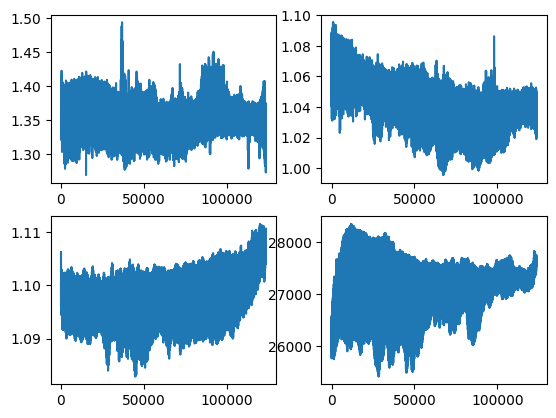

In [13]:
fig, a = plt.subplots(2, 2)
a[0][0].plot(data4bf_fan[data_inds4_fan,0])
a[0][1].plot(data4bf_fan[data_inds4_fan,1])
a[1][0].plot(data4bf_fan[data_inds4_fan,2])
a[1][1].plot(data4bf_fan[data_inds4_fan,3])
plt.show()

In [14]:
# Clean data by removing negative values and assigning no data to -1
# Create flattened array of no_data as -1
cleaned_fanf = np.full(data4bf_fan.shape, -1, dtype='float32');

In [15]:
cleaned_fanf.shape

(181260, 4)

In [16]:
data4bf_fan.shape

(181260, 4)

In [17]:
# Add good data to the array
for i,val in enumerate(data_inds4_fan):
    cleaned_fanf[val,:] = data4bf_fan[val,:]

In [18]:
cleaned_fanf[50000,:]

array([1.3650323e+00, 1.0443432e+00, 1.0934434e+00, 2.7393000e+04],
      dtype=float32)

In [19]:
# Reshape cluster map from flattened to original raster
cleaned_fan = np.reshape(cleaned_fanf, [combined_fan.shape[0], combined_fan.shape[1], combined_fan.shape[2]]);

In [20]:
#assign -1.0 to nan
cleaned_fan[cleaned_fan == -1.0] = np.nan

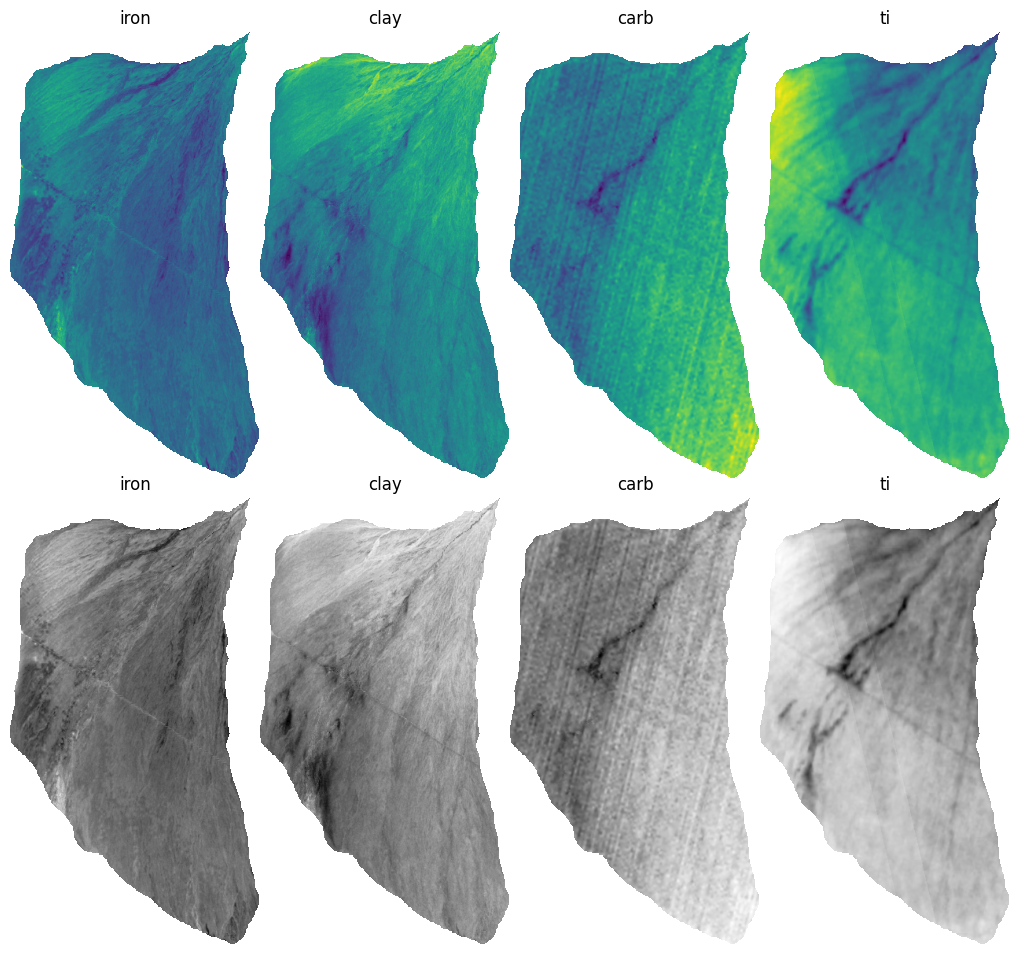

In [21]:
img1 = cleaned_fan[:,:,0]
img2 = cleaned_fan[:,:,1]
img3 = cleaned_fan[:,:,2]
img4 = cleaned_fan[:,:,3]

names = ["iron", "clay", "carb", "ti"]
fig, ax = plt.subplots(2, 4, figsize=(10, 15), facecolor='w')
ax[0,0].imshow(img1, cmap='viridis')
ax[0,1].imshow(img2, cmap='viridis')
ax[0,2].imshow(img3, cmap='viridis')
ax[0,3].imshow(img4, cmap='viridis')
ax[1,0].imshow(img1, cmap='Greys_r')
ax[1,1].imshow(img2, cmap='Greys_r')
ax[1,2].imshow(img3, cmap='Greys_r')
ax[1,3].imshow(img4, cmap='Greys_r')

for i in range(4):
    ax[0,i].set_title(names[i])
    ax[1,i].set_title(names[i])

for a in ax.ravel():
    a.set_axis_off()
plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0, hspace=-0.55)
plt.savefig(results+"input_bands.png")
plt.show()

# Normalize and Scale

In [22]:
# Normalize bands
scaler4_fan = StandardScaler().fit(data4bf_fan[data_inds4_fan]);
data4bf_fan_norm = scaler4_fan.transform(data4bf_fan[data_inds4_fan]);

# PCA

In [23]:
# Run PCA Full Fan
pk = 3;
pca4fan = PCA(n_components=pk, random_state=5);
data_pca4fan = pca4fan.fit_transform(data4bf_fan_norm);

# Create flattened null array of no_data as 0
back_pca4fan = np.full((data4bf_fan.shape[0],3), 0, dtype='float');

# Add PCA values to flattened array
for i in range(data_pca4fan.shape[0]):
    for b in range(data_pca4fan.shape[1]):
        back_pca4fan[data_inds4_fan[i],b] = data_pca4fan[i,b]

# Reshape PCA to raster map
map_pca4fan = np.reshape(back_pca4fan, [data4b_fan.shape[0], data4b_fan.shape[1], data_pca4fan.shape[1]]);

<Figure size 640x480 with 0 Axes>

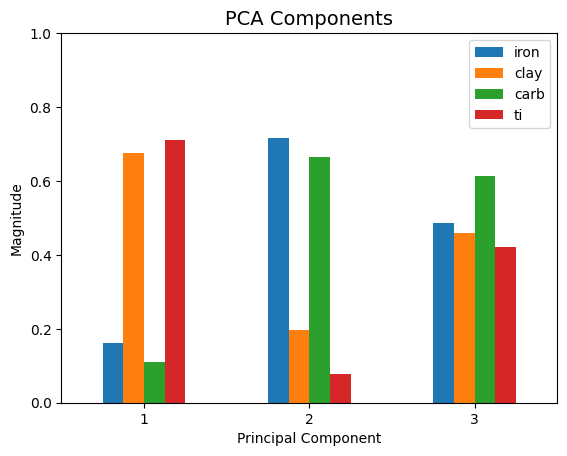

In [24]:
# PCA Components Plot
names = ["iron", "clay", "carb", "ti"]
pc_labels = ['1', '2', '3']
tickvalues = range(0,len(pc_labels))

fig, plt.figure()
pd.DataFrame(np.absolute(pca4fan.components_), columns=names[0:4]).plot(kind='bar', rot=0)
plt.title('PCA Components', fontsize=14)
plt.ylim([0,1])
plt.xticks(ticks = tickvalues ,labels = pc_labels, rotation = 'horizontal')
plt.xlabel('Principal Component')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.savefig(results+"PCA_components.png")

# ICA

In [25]:
# Run ICA
ik = 3;
ica4 = FastICA(n_components=ik, random_state=5);
data_ica4 = ica4.fit_transform(data4bf_fan_norm);
# Create flattened array of no_data as -1
back_ica4 = np.full((data4bf_fan.shape[0],3), 0, dtype='float');
# Add cluster labels to flattened data
for i in range(data_ica4.shape[0]):
    for b in range(data_ica4.shape[1]):
        back_ica4[data_inds4_fan[i],b] = data_ica4[i,b]
# Reshape cluster map to raster
map_ica4 = np.reshape(back_ica4, [data4b_fan.shape[0], data4b_fan.shape[1], data_ica4.shape[1]]);

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

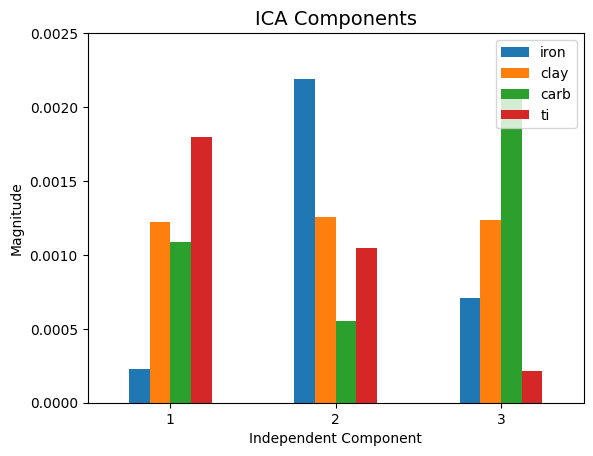

In [26]:
# ICA Components Plot
names = ["iron", "clay", "carb", "ti"]
pc_labels = ['1', '2', '3']
tickvalues = range(0,len(pc_labels))

fig, plt.figure()
pd.DataFrame(np.absolute(ica4.components_), columns=names[0:4]).plot(kind='bar', rot=0)
plt.title('ICA Components', fontsize=14)
plt.ylim([0,0.0025])
plt.xticks(ticks = tickvalues ,labels = pc_labels, rotation = 'horizontal')
plt.xlabel('Independent Component')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.savefig(results+"ICA_components.png")

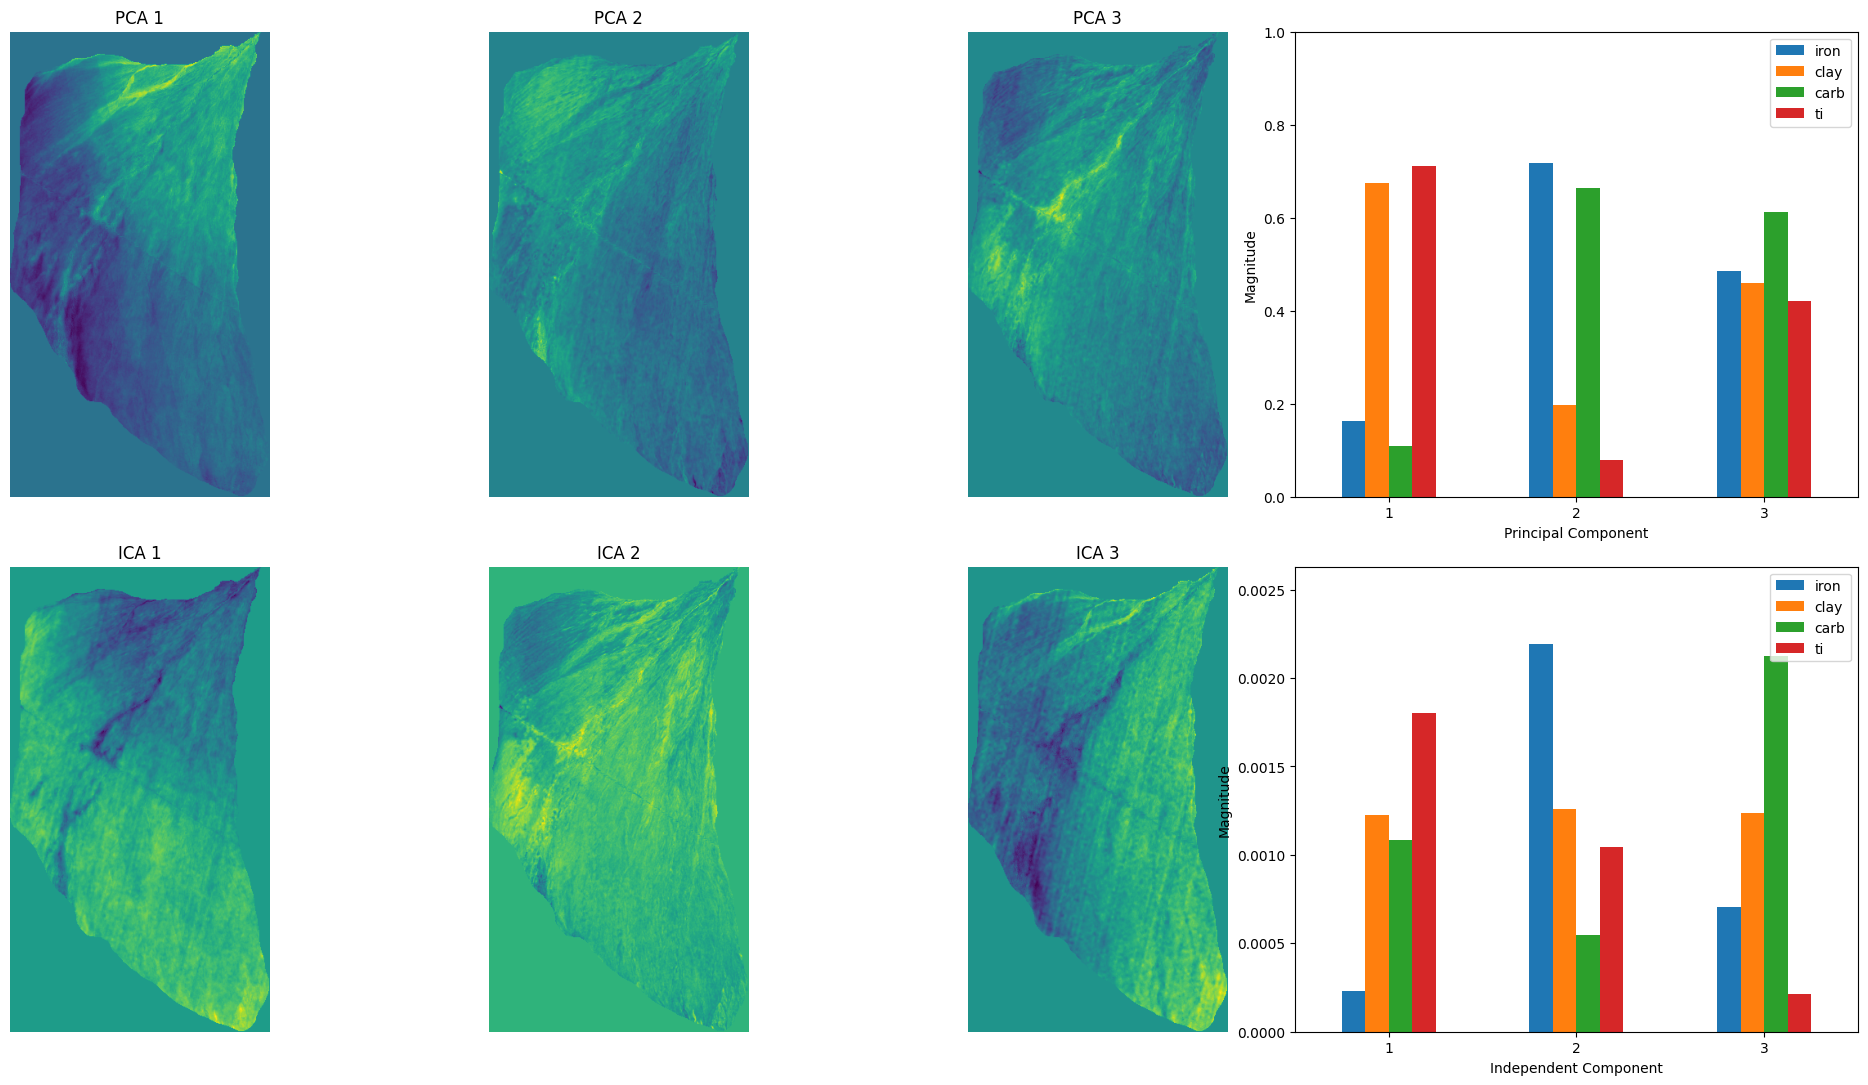

In [27]:
# Maps PCA and ICA
maps = np.array([map_pca4fan[:,:,0], map_pca4fan[:,:,1], map_pca4fan[:,:,2], map_ica4[:,:,0], map_ica4[:,:,1], map_ica4[:,:,2]])
bands = ['4 band', '5 band', '6 band', '7 band']
names = ["iron", "clay", "carb", "ti", "roughness", "ndvi", "detrended"]
pc_labels = ['1', '2', '3', '4', '5', '6']

fig, ax = plt.subplots(2,4, figsize=(20,10), facecolor='w')
for k in range(3):
    map_pca4fan[map_pca4fan == 0] = np.nan
    ax[0][k].imshow(maps[k], cmap='viridis')
    ax[0][k].axis('off')
    ax[0][k].set_title('PCA '+str(k+1))

pd.DataFrame(np.absolute(pca4fan.components_), columns=names[0:4]).plot(kind='bar', ax=ax[0][3], rot=0)
ax[0][3].set_ylim([0,1])
ax[0][3].set_xticklabels(pc_labels[0:3])
ax[0][3].set_xlabel('Principal Component')
ax[0][3].set_ylabel('Magnitude')
ax[0][3].legend(loc='upper right')

for k in range(3):
    map_ica4[map_ica4 == 0] = np.nan
    ax[1][k].imshow(maps[k+3], cmap='viridis')
    ax[1][k].axis('off')
    ax[1][k].set_title('ICA '+str(k+1))

pd.DataFrame(np.absolute(ica4.components_), columns=names[0:4]).plot(kind='bar', ax=ax[1][3], rot=0)
ax[1][3].set_ylim([0,(np.absolute(ica4.components_).max())*1.2])
ax[1][3].set_xticklabels(pc_labels[0:3])
ax[1][3].set_xlabel('Independent Component')
ax[1][3].set_ylabel('Magnitude')
ax[1][3].legend(loc='upper right')

plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=-.15, hspace=0.15)
plt.savefig(results+"PCA_ICA_maps_components.png", bbox_inches='tight')

# K-means

In [28]:
# Run k-means++ on normalized data
k = 4;
kmeans4fan = KMeans(n_clusters=k, random_state=5);
kmeans4fan.fit(data4bf_fan_norm);
k = 5;
kmeans5fan = KMeans(n_clusters=k, random_state=5);
kmeans5fan.fit(data4bf_fan_norm);
k = 6;
kmeans6fan = KMeans(n_clusters=k, random_state=5);
kmeans6fan.fit(data4bf_fan_norm);
k = 7;
kmeans7fan = KMeans(n_clusters=k, random_state=5);
kmeans7fan.fit(data4bf_fan_norm);
# Create flattened array of no_data as -1
clustered_4fan = np.full(data4bf_fan.shape[0], -1, dtype='int32');
clustered_5fan = np.full(data4bf_fan.shape[0], -1, dtype='int32');
clustered_6fan = np.full(data4bf_fan.shape[0], -1, dtype='int32');
clustered_7fan = np.full(data4bf_fan.shape[0], -1, dtype='int32');
# Add cluster labels to flattened data
for i in range(kmeans4fan.labels_.shape[0]):
    clustered_4fan[data_inds4_fan[i]] = kmeans4fan.labels_[i]
for i in range(kmeans5fan.labels_.shape[0]):
    clustered_5fan[data_inds4_fan[i]] = kmeans5fan.labels_[i]
for i in range(kmeans6fan.labels_.shape[0]):
    clustered_6fan[data_inds4_fan[i]] = kmeans6fan.labels_[i]
for i in range(kmeans7fan.labels_.shape[0]):
    clustered_7fan[data_inds4_fan[i]] = kmeans7fan.labels_[i]
# Reshape cluster map to raster
clustered4fan = np.reshape(clustered_4fan, [data4b_fan.shape[0], data4b_fan.shape[1]]);
clustered5fan = np.reshape(clustered_5fan, [data4b_fan.shape[0], data4b_fan.shape[1]]);
clustered6fan = np.reshape(clustered_6fan, [data4b_fan.shape[0], data4b_fan.shape[1]]);
clustered7fan = np.reshape(clustered_7fan, [data4b_fan.shape[0], data4b_fan.shape[1]]);

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
# Run k-means++ after running PCA on normalized data
k = 4;
kmeansp4fan = KMeans(n_clusters=k, random_state=5);
kmeansp4fan.fit(data_pca4fan);
k = 5;
kmeansp5fan = KMeans(n_clusters=k, random_state=5);
kmeansp5fan.fit(data_pca4fan);
k = 6;
kmeansp6fan = KMeans(n_clusters=k, random_state=5);
kmeansp6fan.fit(data_pca4fan);
k = 7;
kmeansp7fan = KMeans(n_clusters=k, random_state=5);
kmeansp7fan.fit(data_pca4fan);
# Create flattened array of no_data as -1
clustered_pca4fan = np.full(data4bf_fan.shape[0], -1, dtype='int32');
clustered_pca5fan = np.full(data4bf_fan.shape[0], -1, dtype='int32');
clustered_pca6fan = np.full(data4bf_fan.shape[0], -1, dtype='int32');
clustered_pca7fan = np.full(data4bf_fan.shape[0], -1, dtype='int32');
# Add cluster labels to flattened data
for i in range(kmeansp4fan.labels_.shape[0]):
    clustered_pca4fan[data_inds4_fan[i]] = kmeansp4fan.labels_[i]
for i in range(kmeansp5fan.labels_.shape[0]):
    clustered_pca5fan[data_inds4_fan[i]] = kmeansp5fan.labels_[i]
for i in range(kmeansp6fan.labels_.shape[0]):
    clustered_pca6fan[data_inds4_fan[i]] = kmeansp6fan.labels_[i]
for i in range(kmeansp7fan.labels_.shape[0]):
    clustered_pca7fan[data_inds4_fan[i]] = kmeansp7fan.labels_[i]
# Reshape cluster map to raster
clusteredp4fan = np.reshape(clustered_pca4fan, [data4b_fan.shape[0], data4b_fan.shape[1]]);
clusteredp5fan = np.reshape(clustered_pca5fan, [data4b_fan.shape[0], data4b_fan.shape[1]]);
clusteredp6fan = np.reshape(clustered_pca6fan, [data4b_fan.shape[0], data4b_fan.shape[1]]);
clusteredp7fan = np.reshape(clustered_pca7fan, [data4b_fan.shape[0], data4b_fan.shape[1]]);

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Gaussian Mixture Model

In [30]:
# Run gaussian mixture on 4 band dataset
gk = 4;   # number of clusters
gm4k4 = GaussianMixture(n_components=gk, random_state=0).fit(data4bf_fan_norm);
labelsgm4k4 = gm4k4.predict(data4bf_fan_norm);
gk = 5;   # number of clusters
gm4k5 = GaussianMixture(n_components=gk, random_state=0).fit(data4bf_fan_norm);
labelsgm4k5 = gm4k5.predict(data4bf_fan_norm);
gk = 6;   # number of clusters
gm4k6 = GaussianMixture(n_components=gk, random_state=0).fit(data4bf_fan_norm);
labelsgm4k6 = gm4k6.predict(data4bf_fan_norm);
gk = 7;   # number of clusters
gm4k7 = GaussianMixture(n_components=gk, random_state=0).fit(data4bf_fan_norm);
labelsgm4k7 = gm4k7.predict(data4bf_fan_norm);

In [31]:
# GMM k=6
# Create flattened array of no_data as -1
clusteredfg_4k4 = np.full(data4bf_fan.shape[0], -1, dtype='int32');
clusteredfg_4k5 = np.full(data4bf_fan.shape[0], -1, dtype='int32');
clusteredfg_4k6 = np.full(data4bf_fan.shape[0], -1, dtype='int32');
clusteredfg_4k7 = np.full(data4bf_fan.shape[0], -1, dtype='int32');
# Add cluster labels to flattened data
for i in range(labelsgm4k4.shape[0]):
    clusteredfg_4k4[data_inds4_fan[i]] = labelsgm4k4[i]
for i in range(labelsgm4k5.shape[0]):
    clusteredfg_4k5[data_inds4_fan[i]] = labelsgm4k5[i]
for i in range(labelsgm4k6.shape[0]):
    clusteredfg_4k6[data_inds4_fan[i]] = labelsgm4k6[i]
for i in range(labelsgm4k7.shape[0]):
    clusteredfg_4k7[data_inds4_fan[i]] = labelsgm4k7[i]
# Reshape cluster map to raster
clusteredg4k4 = np.reshape(clusteredfg_4k4, [data4b_fan.shape[0], data4b_fan.shape[1]]);
clusteredg4k5 = np.reshape(clusteredfg_4k5, [data4b_fan.shape[0], data4b_fan.shape[1]]);
clusteredg4k6 = np.reshape(clusteredfg_4k6, [data4b_fan.shape[0], data4b_fan.shape[1]]);
clusteredg4k7 = np.reshape(clusteredfg_4k7, [data4b_fan.shape[0], data4b_fan.shape[1]]);

# Maps

In [32]:
# Define colors of clusters
none, pink, blue, green, lightblue, gold, orange, brown = "#ffffff00", "#fb62af", "#3f60c3", "#338b3d", "#39b3eb", "#d2d943", "#ff7f0e", "#b3530d"

In [33]:
# Create color maps manually for consistency as assigned cluster numbers shift randomly
cmapk4 = mpl.colors.ListedColormap([none, green, lightblue, blue, pink])
cmapk5 = mpl.colors.ListedColormap([none, gold, lightblue, green, pink, blue])
cmapk6 = mpl.colors.ListedColormap([none, pink, gold, lightblue, green, blue, brown])
cmapk7 = mpl.colors.ListedColormap([none, gold, lightblue, orange, pink, blue, green, brown])
cmapp4 = mpl.colors.ListedColormap([none, blue, green, lightblue, pink])
cmapp5 = mpl.colors.ListedColormap([none, lightblue, blue, pink, green, gold])
cmapp6 = mpl.colors.ListedColormap([none, brown, pink, gold, green, lightblue, blue])
cmapp7 = mpl.colors.ListedColormap([none, lightblue, gold, orange, green, blue, brown, pink])
cmapg4 = mpl.colors.ListedColormap([none, lightblue, pink, blue, green])
cmapg5 = mpl.colors.ListedColormap([none, lightblue, gold, blue, green, pink])
cmapg6 = mpl.colors.ListedColormap([none, lightblue , brown, blue, green, pink, gold])
cmapg7 = mpl.colors.ListedColormap([none, orange, brown, blue, green, lightblue, gold, pink])

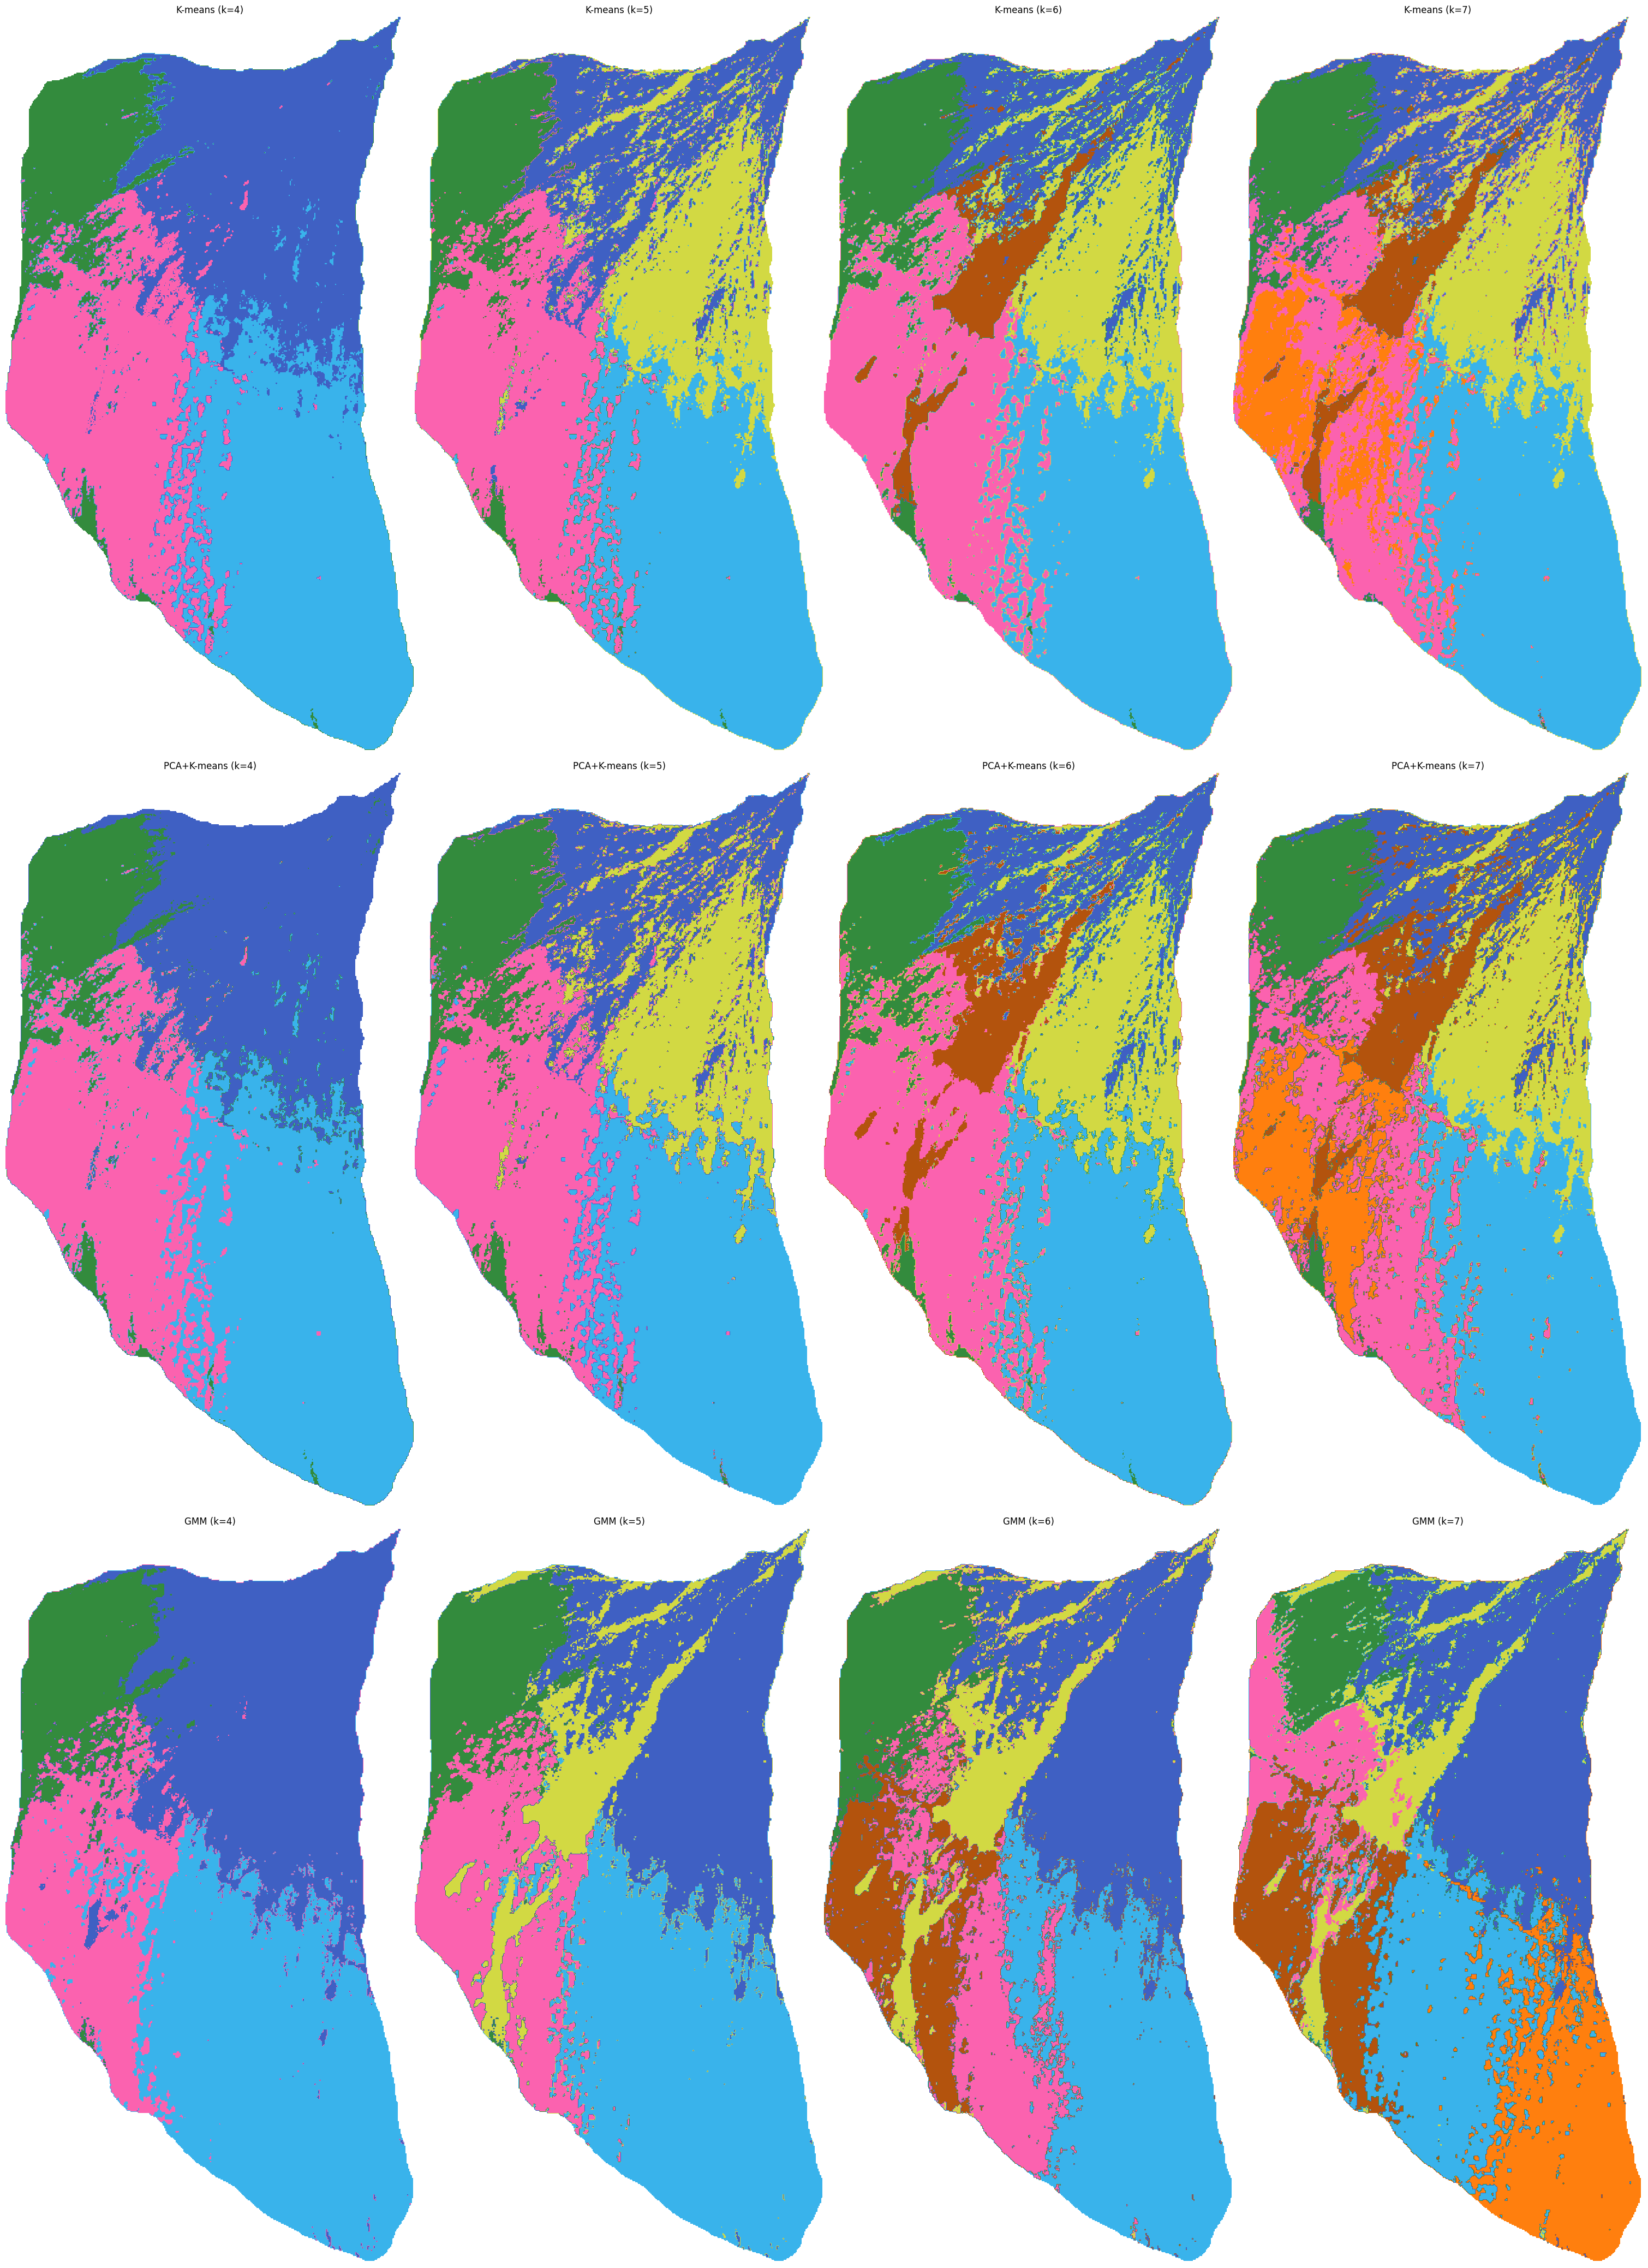

In [34]:
# Maps Plot full fan
cmapjk = np.reshape([cmapk4,cmapk5,cmapk6,cmapk7,cmapp4,cmapp5,cmapp6,cmapp7,cmapg4,cmapg5,cmapg6,cmapg7], (3,4))
clusteredpgfan = np.array([clustered4fan, clustered5fan, clustered6fan, clustered7fan, clusteredp4fan, clusteredp5fan, clusteredp6fan, clusteredp7fan, clusteredg4k4, clusteredg4k5, clusteredg4k6, clusteredg4k7])
titlesjk = np.reshape(['K-means (k=4)','K-means (k=5)','K-means (k=6)','K-means (k=7)','PCA+K-means (k=4)','PCA+K-means (k=5)','PCA+K-means (k=6)','PCA+K-means (k=7)','GMM (k=4)','GMM (k=5)','GMM (k=6)','GMM (k=7)'], (3,4))

fig, ax = plt.subplots(3,4, figsize=(30,45), facecolor='w')
for j in range(3):
    for k in range(4):
        ax[j][k].imshow(clusteredpgfan[(j*4)+k], cmap=cmapjk[j,k])
        ax[j][k].axis('off')
        ax[j][k].set_title(titlesjk[j,k])

plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0, hspace=-.2)
plt.savefig(results+"maps.png", bbox_inches='tight')

# Save Maps

In [36]:
# Write GeoTiff Full Fan
filename = '4band_fan_iron_clay_carb_ti_pk6.tif'
kmeans_raster = rasterio.open(results+filename, 'w', driver='GTiff',
                            height = clusteredp4fan.shape[0], width = clusteredp4fan.shape[1],
                            count=1, dtype='int32',
                            crs='+proj=utm +zone=11 +ellps=GRS80 +datum=WGS84 +units=m +no_defs',
                            transform=from_origin(422280, 4131570, 30.0, 30.0))

kmeans_raster.write(clusteredp6fan, 1)
kmeans_raster.close()

# Comparison and Data Analysis

In [37]:
# Create color maps manually for consistency as assigned cluster numbers shift randomly
# Same as for above maps, but with transparent 'none' color removed
c1 = [green, lightblue, blue, pink]
c2 = [gold, lightblue, green, pink, blue]
c3 = [pink, gold, lightblue, green, blue, brown]
c4 = [gold, lightblue, orange, pink, blue, green, brown]
c5 = [blue, green, lightblue, pink]
c6 = [lightblue, blue, pink, green, gold]
c7 = [brown, pink, gold, green, lightblue, blue]
c8 = [lightblue, gold, orange, green, blue, brown, pink]
c9 = [lightblue, pink, blue, green]
c10 = [lightblue, gold, blue, green, pink]
c11 = [lightblue , brown, blue, green, pink, gold]
c12 = [orange, brown, blue, green, lightblue, gold, pink]

In [38]:
kmeans4fan.labels_.shape

(123609,)

In [39]:
data_pca4fan.shape

(123609, 3)

In [40]:
kmeansp4fan.labels_.shape

(123609,)

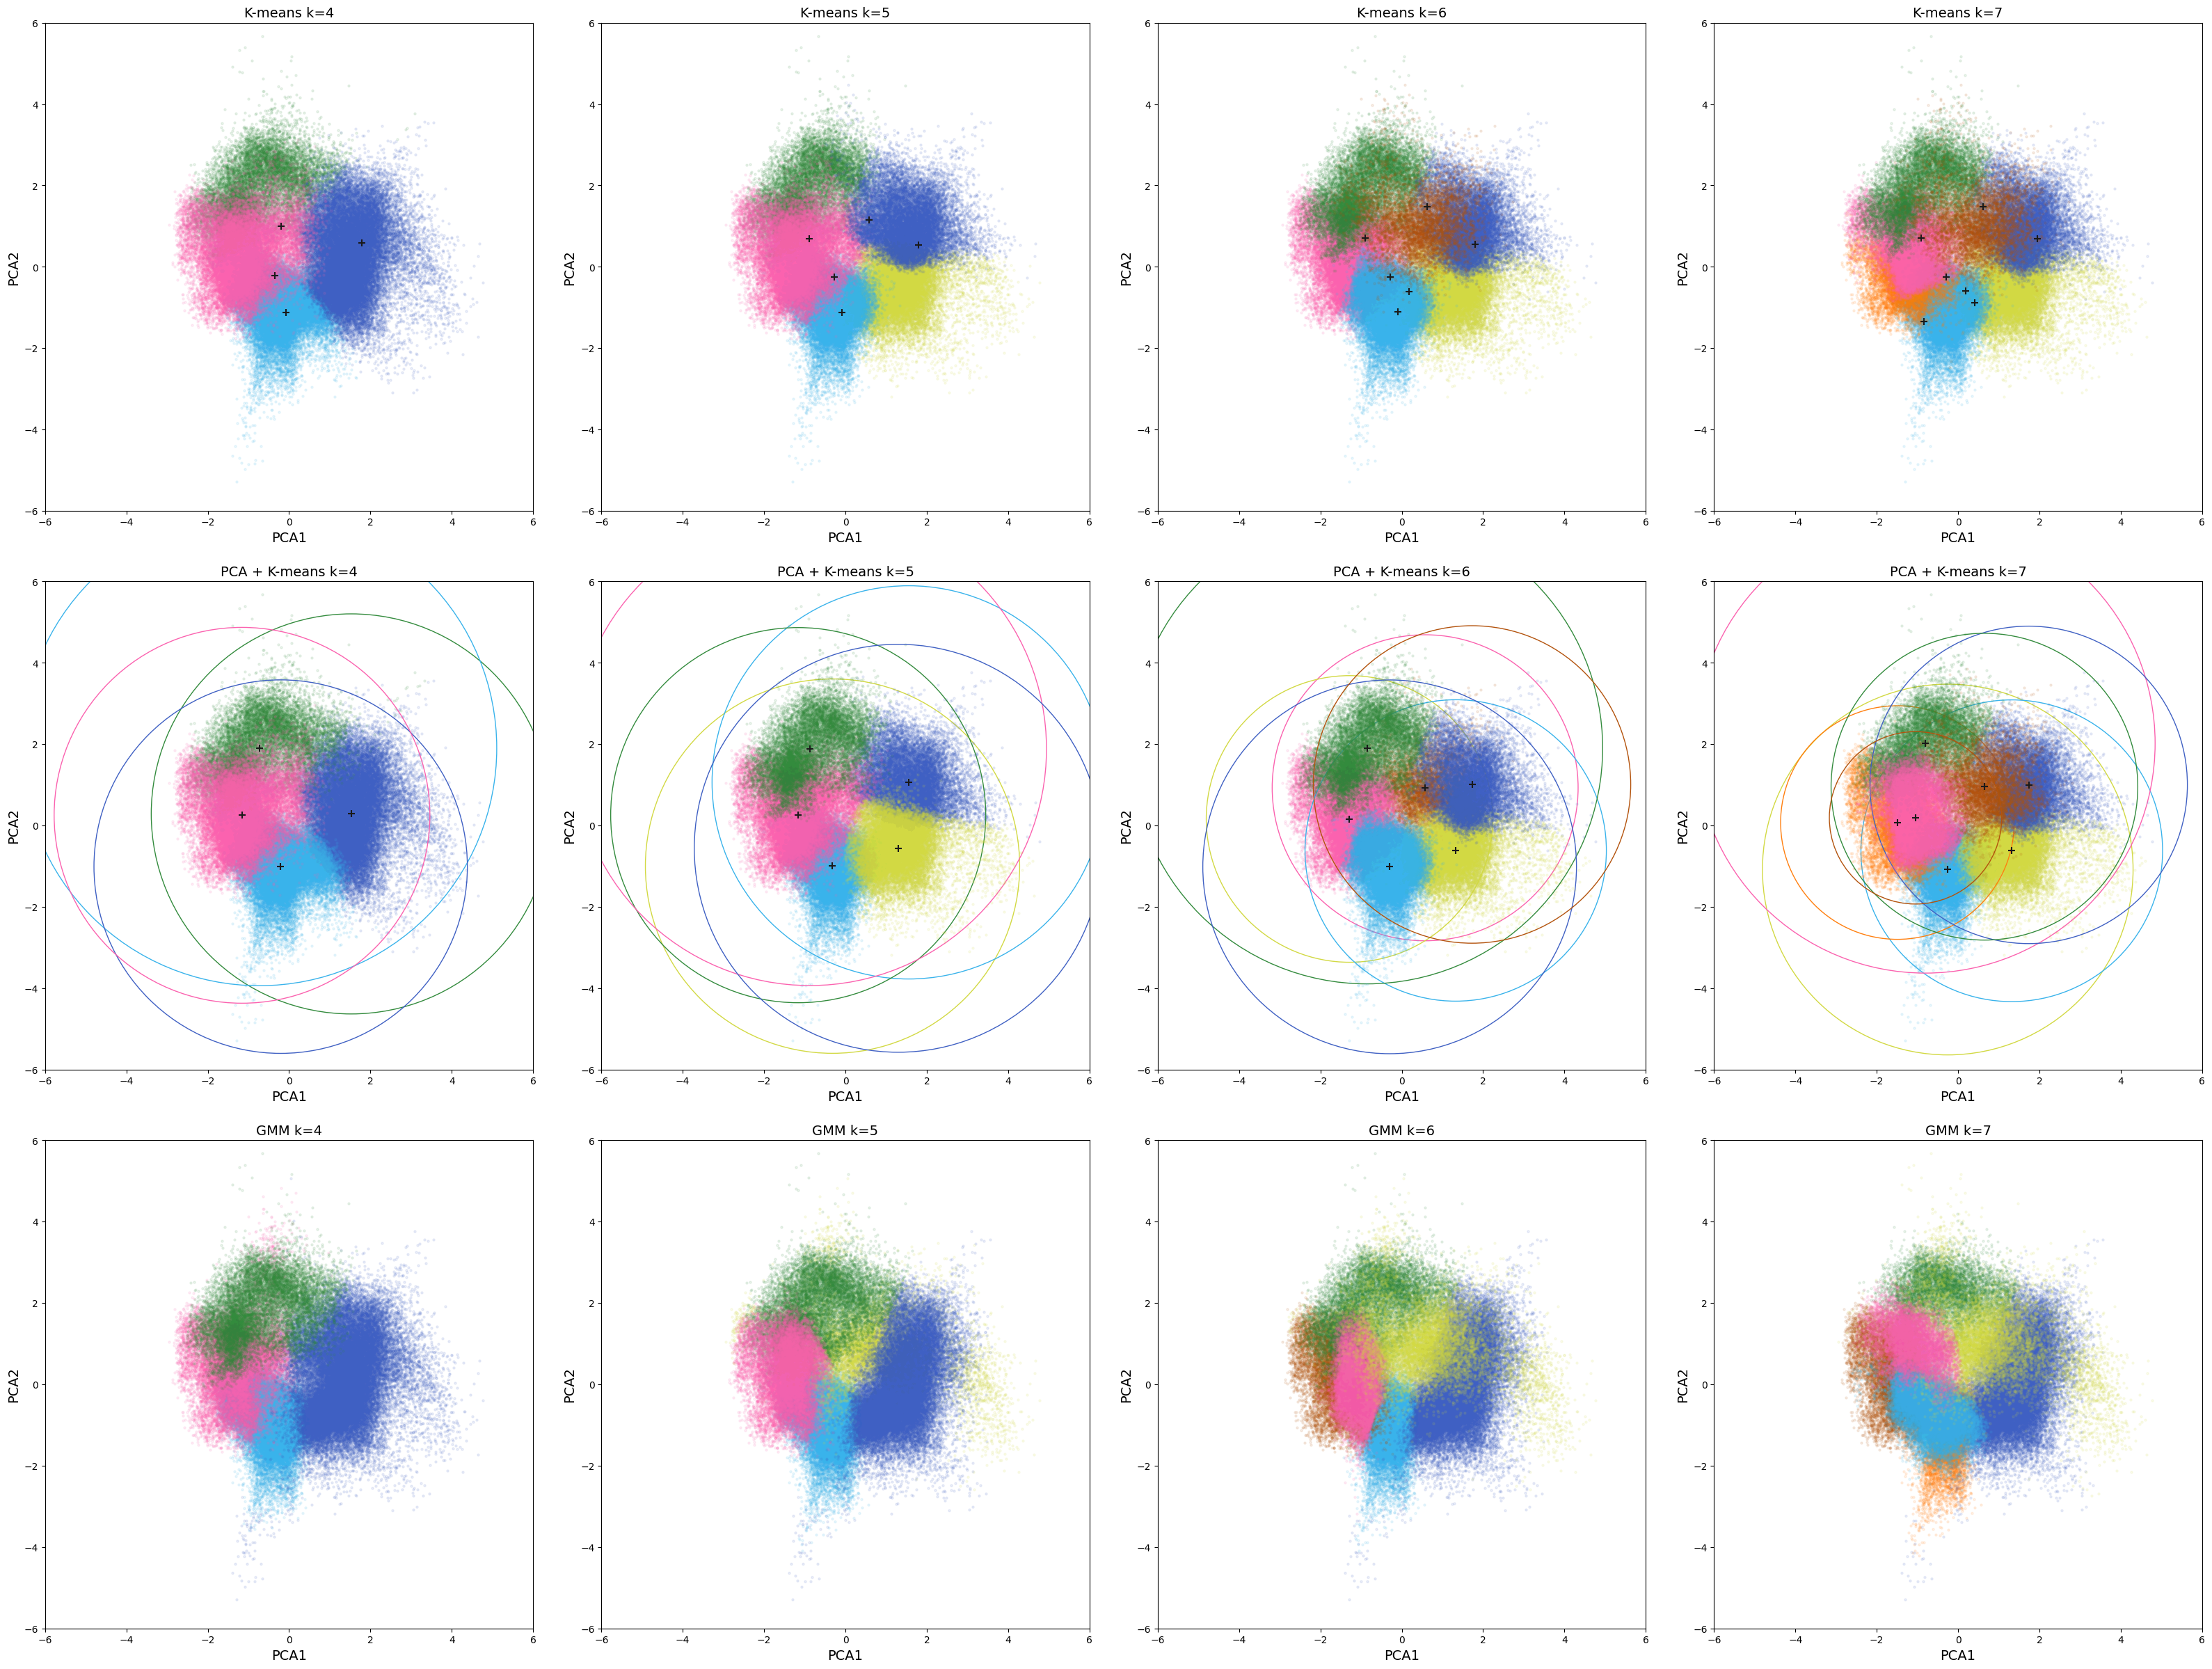

In [41]:
# Plot PCA1 v PCA2 for cluster methods
n_clusters = 4
fig, ax = plt.subplots(3, 4, figsize=(40,30), facecolor='w')
colors = [c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12]
kmeans = [kmeans4fan, kmeans5fan, kmeans6fan, kmeans7fan]
kmeansp = [kmeansp4fan, kmeansp5fan, kmeansp6fan, kmeansp7fan]
gmms = [labelsgm4k4,labelsgm4k5,labelsgm4k6,labelsgm4k7]
title = ['4', '5', '6', '7']

# Plots kmeans k=4,5,6,7
for k in range(4):
    for i in range(n_clusters+k):
        ax[0][k].scatter(data_pca4fan[:,0].flatten()[np.where(kmeans[k].labels_==i)],
                    data_pca4fan[:,1].flatten()[np.where(kmeans[k].labels_==i)],
                    label='Cluster %d' % i, s=5, alpha=0.1, c=colors[k][i])
        # r = cdist(data_pca4fan[np.where(kmeans[k].labels_==i)], [kmeans[k].cluster_centers_[i,:]]).max()
        # ax[1][k].add_artist(plt.Circle((kmeans[k].cluster_centers_[i,0], kmeans[k].cluster_centers_[i,1]),
        #     r, fill=False, color=colors[k][i]))
    ax[0][k].scatter(kmeans[k].cluster_centers_[:,0], kmeans[k].cluster_centers_[:,1], marker='+', s=50, c='k')
    ax[0][k].set_xlabel('PCA1', fontsize=14)
    ax[0][k].set_ylabel('PCA2', fontsize=14)
    ax[0][k].set_title('K-means k='+title[k], fontsize=14)
    ax[0][k].set(aspect='equal')
    ax[0][k].set_ylim([-6,6])
    ax[0][k].set_xlim([-6,6])

# Plots pca + kmeans k=4,5,6,7
for k in range(4):
    for i in range(n_clusters+k):
        ax[1][k].scatter(data_pca4fan[:,0].flatten()[np.where(kmeansp[k].labels_==i)],
                    data_pca4fan[:,1].flatten()[np.where(kmeansp[k].labels_==i)],
                    label='Cluster %d' % i, s=5, alpha=0.1, c=colors[k+4][i])
        r = cdist(data_pca4fan[np.where(kmeansp[k].labels_==i)], [kmeansp[k].cluster_centers_[i,:]]).max()
        ax[1][k].add_artist(plt.Circle((kmeansp[k].cluster_centers_[i,0], kmeansp[k].cluster_centers_[i,1]),
            r, fill=False, color=colors[k][i]))
    ax[1][k].scatter(kmeansp[k].cluster_centers_[:,0], kmeansp[k].cluster_centers_[:,1], marker='+', s=50, c='k')
    ax[1][k].set_xlabel('PCA1', fontsize=14)
    ax[1][k].set_ylabel('PCA2', fontsize=14)
    ax[1][k].set_title('PCA + K-means k='+title[k], fontsize=14)
    ax[1][k].set(aspect='equal')
    ax[1][k].set_ylim([-6,6])
    ax[1][k].set_xlim([-6,6])

# Plots GMM k=4,5,6,7
for k in range(4):
    for i in range(n_clusters+k):
        ax[2][k].scatter(data_pca4fan[:,0].flatten()[np.where(gmms[k]==i)],
                    data_pca4fan[:,1].flatten()[np.where(gmms[k]==i)],
                    label='Cluster %d' % i, s=5, alpha=0.1, c=colors[k+8][i])
    ax[2][k].set_xlabel('PCA1', fontsize=14)
    ax[2][k].set_ylabel('PCA2', fontsize=14)
    ax[2][k].set_title('GMM k='+title[k], fontsize=14)
    ax[2][k].set(aspect='equal')
    ax[2][k].set_ylim([-6,6])
    ax[2][k].set_xlim([-6,6])

plt.subplots_adjust(hspace=0.14, wspace=0.14)
plt.savefig(results+"Point_clouds_clustered.png", bbox_inches='tight')
plt.show()

In [42]:
# Calculate fraction of fan in each cluster
k4s = [kmeans4fan,kmeansp4fan,labelsgm4k4]
k5s = [kmeans5fan,kmeansp5fan,labelsgm4k5]
k6s = [kmeans6fan,kmeansp6fan,labelsgm4k6]
k7s = [kmeans7fan,kmeansp7fan,labelsgm4k7]
percentsk4 = np.full((3,4), 1.0)
percentsk5 = np.full((3,5), 1.0)
percentsk6 = np.full((3,6), 1.0)
percentsk7 = np.full((3,7), 1.0)

# all models with k=4
for k in range(4):
    percentsk4[0,k] = (len(list(set(np.where(k4s[0].labels_ == k)[0])))*100/k4s[0].labels_.shape[0])
    percentsk4[1,k] = (len(list(set(np.where(k4s[1].labels_ == k)[0])))*100/k4s[1].labels_.shape[0])
    percentsk4[2,k] = (len(list(set(np.where(k4s[2] == k)[0])))*100/k4s[2].shape[0])

# all models with k=5
for k in range(5):
    percentsk5[0,k] = (len(list(set(np.where(k5s[0].labels_ == k)[0])))*100/k5s[0].labels_.shape[0])
    percentsk5[1,k] = (len(list(set(np.where(k5s[1].labels_ == k)[0])))*100/k5s[1].labels_.shape[0])
    percentsk5[2,k] = (len(list(set(np.where(k5s[2] == k)[0])))*100/k5s[2].shape[0])

# all models with k=6
for k in range(6):
    percentsk6[0,k] = (len(list(set(np.where(k6s[0].labels_ == k)[0])))*100/k6s[0].labels_.shape[0])
    percentsk6[1,k] = (len(list(set(np.where(k6s[1].labels_ == k)[0])))*100/k6s[1].labels_.shape[0])
    percentsk6[2,k] = (len(list(set(np.where(k6s[2] == k)[0])))*100/k6s[2].shape[0])

# all models with k=7
for k in range(7):
    percentsk7[0,k] = (len(list(set(np.where(k7s[0].labels_ == k)[0])))*100/k7s[0].labels_.shape[0])
    percentsk7[1,k] = (len(list(set(np.where(k7s[1].labels_ == k)[0])))*100/k7s[1].labels_.shape[0])
    percentsk7[2,k] = (len(list(set(np.where(k7s[2] == k)[0])))*100/k7s[2].shape[0])

# Print Example Results
for i in range(7):
    print(f"{percentsk7[0,i]:.1f}" + "% cluster " + str(i))

17.7% cluster 0
30.7% cluster 1
8.7% cluster 2
16.3% cluster 3
12.5% cluster 4
8.6% cluster 5
5.5% cluster 6


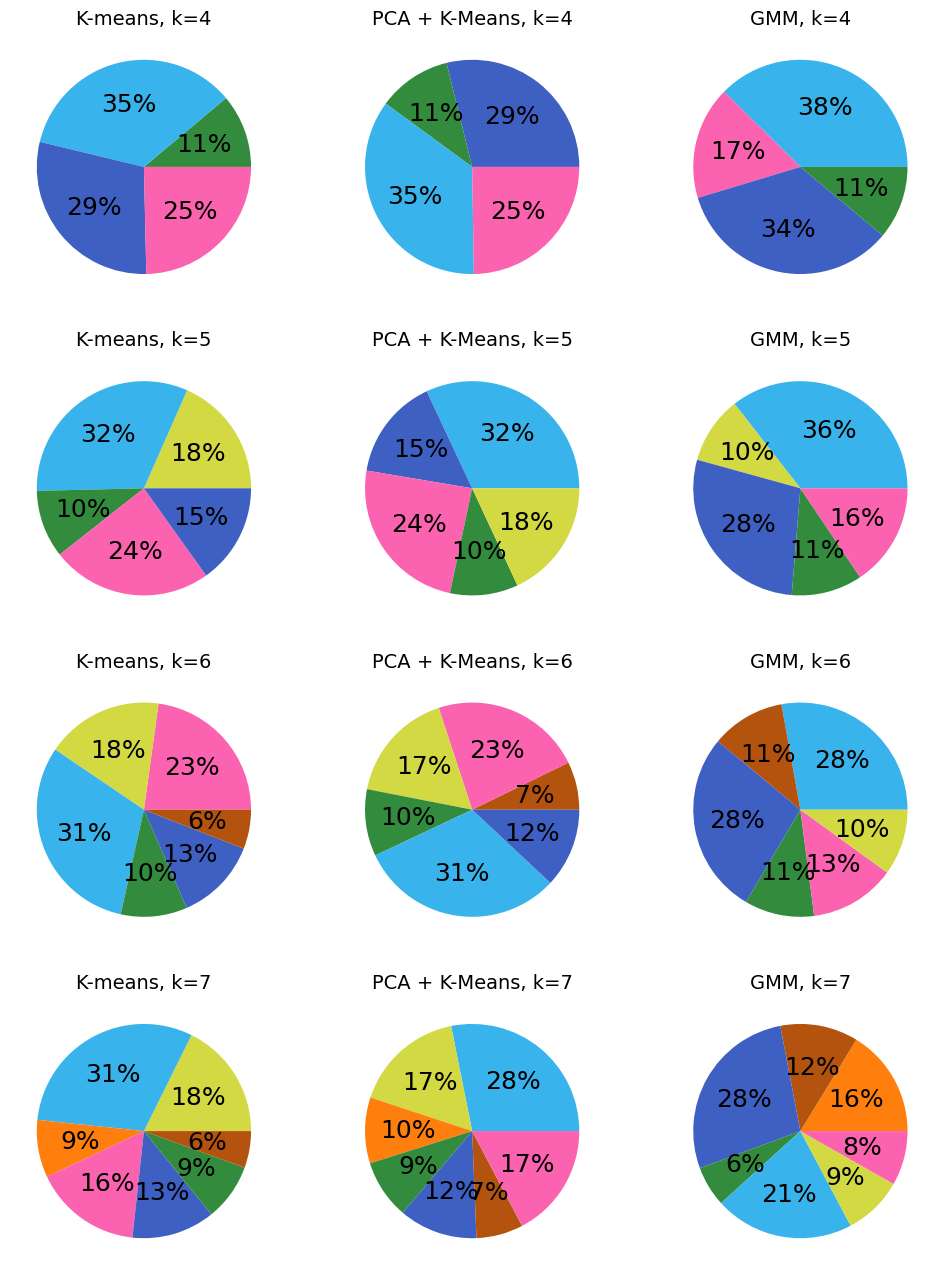

In [43]:
# Pie Charts Percents
colors = [c1,c5,c9,c2,c6,c10,c3,c7,c11,c4,c8,c12]
cols = ['K-means', 'PCA + K-Means', 'GMM']
fig, ax = plt.subplots(4,3, figsize=(12,16), facecolor='w')
# all models with k=4
for k in range(3):
    ax[0][k].pie(percentsk4[k,:], autopct='%1.0f%%', textprops={'fontsize':18}, colors=colors[k])
    ax[0][k].set_title(cols[k] + ', k=4', fontsize=14)
# all models with k=5
for k in range(3):
    ax[1][k].pie(percentsk5[k,:], autopct='%1.0f%%', textprops={'fontsize':18}, colors=colors[k+3])
    ax[1][k].set_title(cols[k] + ', k=5', fontsize=14)
# all models with k=6
for k in range(3):
    ax[2][k].pie(percentsk6[k,:], autopct='%1.0f%%', textprops={'fontsize':18}, colors=colors[k+6])
    ax[2][k].set_title(cols[k] + ', k=6', fontsize=14)
# all models with k=7
for k in range(3):
    ax[3][k].pie(percentsk7[k,:], autopct='%1.0f%%', textprops={'fontsize':18}, colors=colors[k+9])
    ax[3][k].set_title(cols[k] + ', k=7', fontsize=14)
plt.savefig(results+"Pie_charts.png", bbox_inches='tight')

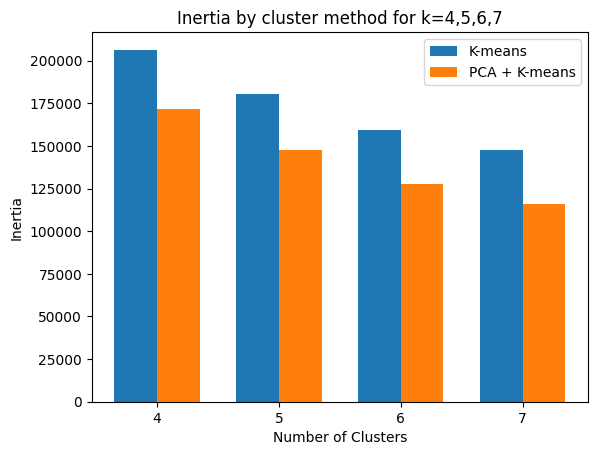

In [44]:
# Plot inertia 'k-means' and 'pca + k-means'
inert_k = kmeans4fan.inertia_, kmeans5fan.inertia_, kmeans6fan.inertia_, kmeans7fan.inertia_
inert_pk = kmeansp4fan.inertia_, kmeansp5fan.inertia_, kmeansp6fan.inertia_, kmeansp7fan.inertia_
in_labels = ['4', '5', '6', '7']

x = np.arange(len(in_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(facecolor='w')
rects1 = ax.bar(x - width/2, inert_k, width, label='K-means')
rects2 = ax.bar(x + width/2, inert_pk, width, label='PCA + K-means')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Inertia')
ax.set_xlabel('Number of Clusters')
ax.set_title('Inertia by cluster method for k=4,5,6,7')
ax.set_xticks(x)
ax.set_xticklabels(in_labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# fig.tight_layout()
plt.savefig(results+"Inertia.png", bbox_inches='tight')
plt.show()

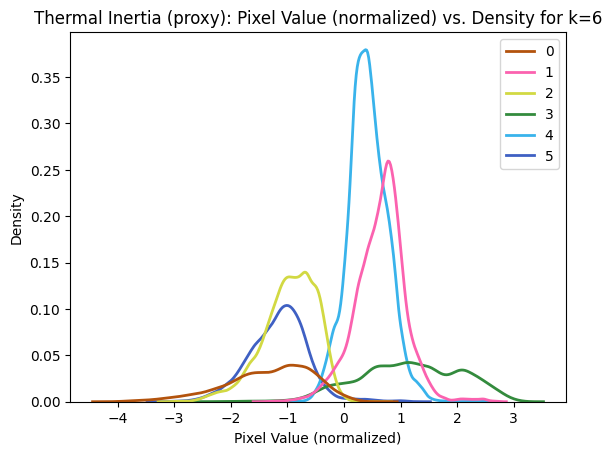

In [45]:
qgis_palette = [brown, pink, gold, green, lightblue, blue]; # get order from above maps
titles = ["Iron (b5/b2)", "Clay (b6/b7)", "Carbonates (b10/b11)", "Thermal Inertia (proxy)"];
names = ["iron", "clay", "carb", "ti"];
n_clusters = 6

for i in range(len(titles)):
    plt.close()
    plt.clf()
    plt.cla()
    plt.xlabel("Pixel Value (normalized)")
    plt.ylabel("Density")
    plt.title(titles[i]+": Pixel Value (normalized) vs. Density for k=6")

    cls = []
    for j in range(n_clusters):
#         cls.append(data4bf_fan_norm[list(set(np.where(kmeansp6fan.labels_ == j)[0])),i])
        cls.append(data4bf_fan_norm[list(set(np.where(kmeansp6fan.labels_ == j)[0])),i])
    sns.kdeplot(data=cls, fill=False, common_norm=True,
            palette=qgis_palette, linewidth=2)

# Save all histograms as .png
    plt.savefig(results+"kde_"+names[i]+"_4band_k6_fan.png")

In [46]:
## Takes ~30-60 min to run !!
## Scatter plots with bulk histogram

# sns.set_style("white")

# names4 = ["iron", "clay", "carb", "ti"]
# data4 = [data4bf_fan_norm[:,0], data4bf_fan_norm[:,1], data4bf_fan_norm[:,2], data4bf_fan_norm[:,3]]

# for combo4, titles4 in zip(combinations(data4, 2), combinations(names4, 2)):
#     x = combo4[0]
#     y = combo4[1]

#     g = sns.JointGrid(space=0)
# #                       xlim=(-4, 4), ylim=(-4, 4))

#     correlation_matrix = np.corrcoef(x, y)
#     correlation_xy = correlation_matrix[0,1]
#     r_squared = correlation_xy**2
#     r, p = sp.stats.pearsonr(x, y)
#     m, b = np.polyfit(x, y, 1)
#     xy = np.vstack([x,y])
#     z = gaussian_kde(xy)(xy)

#     sns.scatterplot(x=x, y=y, c=z, s=5, ec="none", alpha=0.3, cmap="magma", linewidth=1.5, ax=g.ax_joint)

#     # sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
#     sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, c="k")
#     sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, c="k")

#     idx = z.argsort()
#     x, y, z = x[idx], y[idx], z[idx]
#     g.ax_joint.plot(x, m*x + b, c='k', lw=3, ls=':')
#     g.ax_joint.text(.99, .01, '{:.2f}'.format(r),
#         size=20, horizontalalignment='right', verticalalignment='bottom', transform=g.ax_joint.transAxes)

#     g.ax_joint.set_xlabel(titles4[0], fontsize=20)
#     g.ax_joint.set_ylabel(titles4[1], fontsize=20)

#     g.savefig(results+"scatter_kde_"+titles4[0]+"_"+titles4[1]+"_4b_fan_a3.png")

In [47]:
# # Takes ~30-60 min to run !!
# # Correlation of data bands all combinations
# names4 = ["iron", "clay", "carb", "ti"]
# names7 = ["iron", "clay", "carb", "ti", "roughness", "ndvi", "detrended"]
# data4 = [data4bf_fan_norm[:,0], data4bf_fan_norm[:,1], data4bf_fan_norm[:,2], data4bf_fan_norm[:,3]]

# # zipped4 = zip(data4, names4)

# fig, ax = plt.subplots(1, 6, figsize=(48,8), facecolor='w')

# # top row 4 bands
# i=0
# for combo4, titles4 in zip(combinations(data4, 2), combinations(names4, 2)):
#     x = combo4[0]
#     y = combo4[1]
# #     correlation_matrix = np.corrcoef(x, y)
# #     correlation_xy = correlation_matrix[0,1]
# #     r_squared = correlation_xy**2
#     r, p = sp.stats.pearsonr(x, y)
#     m, b = np.polyfit(x, y, 1)
#     xy = np.vstack([x,y])
#     z = gaussian_kde(xy)(xy)
#     idx = z.argsort()
#     x, y, z = x[idx], y[idx], z[idx]

#     ax[i].scatter(x, y, c=z, s=5, alpha=0.3)
#     ax[i].plot(x, m*x + b, c='k', lw=3, ls=':')
#     ax[i].text(.99, .01, '{:.2f}'.format(r),
#             size=20, horizontalalignment='right', verticalalignment='bottom',
#             transform=ax[i].transAxes)
#     ax[i].set_xlabel(titles4[0], fontsize=20)
#     ax[i].set_ylabel(titles4[1], fontsize=20)
#     i += 1

# plt.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.show()

# # +' P: '+'{:.2e}'.format(p)
# # 'Pearson R: '+

In [48]:
# BIC for GMM
max_clusters = 10
covariance_type = ['spherical', 'tied', 'diag', 'full']
scoreg4 = np.full((len(covariance_type),max_clusters), fill_value=1.0)
for i in range(len(covariance_type)):
    for j in range(max_clusters):
        gmm = GaussianMixture(n_components=j+1, random_state=0, covariance_type=covariance_type[i])
        gmm.fit(data4bf_fan_norm)
        scoreg4[i,j] = gmm.bic(data4bf_fan_norm)

In [49]:
# AIC for GMM
max_clusters = 10
covariance_type = ['full']
scorega4 = np.full((len(covariance_type),max_clusters), fill_value=1.0)
for i in range(len(covariance_type)):
    for j in range(max_clusters):
        gmm = GaussianMixture(n_components=j+1, random_state=0, covariance_type=covariance_type[i])
        gmm.fit(data4bf_fan_norm)
        scorega4[i,j] = gmm.aic(data4bf_fan_norm)

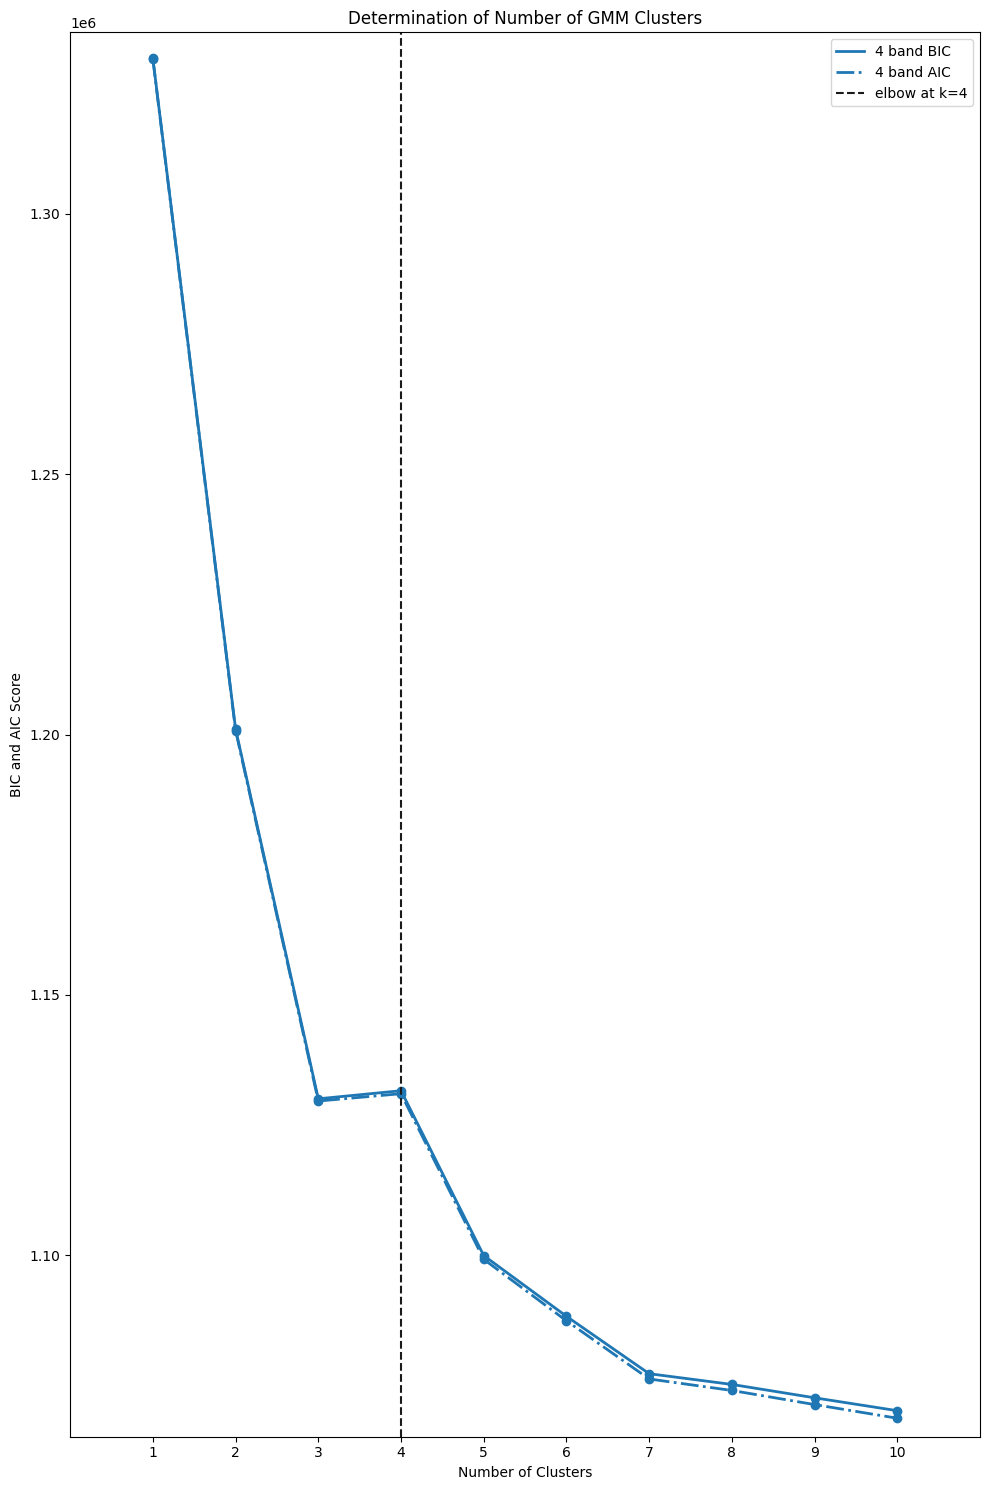

In [50]:
# Plot BIC 'full' and AIC 'full'
fig, ax_s = plt.subplots(1, figsize=(10,15), facecolor='w')

plt.plot(range(1,max_clusters+1), scoreg4[3,:], 'o-', c='C0', linewidth=2, label='4 band BIC')
plt.plot(range(1,max_clusters+1), scorega4[0,:], 'o-.', c='C0', linewidth=2, label='4 band AIC')


plt.vlines(4, scoreg4[3,:].min()-5000,scoreg4[3,:].max()+5000, colors='k', linestyles='dashed', label='elbow at k=4')
plt.legend(loc='upper right', markerscale=0)
ax_s.set_title('Determination of Number of GMM Clusters')
ax_s.set_xlabel('Number of Clusters')
ax_s.set_ylabel('BIC and AIC Score')
ax_s.set_ylim([scoreg4[3,:].min()-5000,scoreg4[3,:].max()+5000])
ax_s.set_xlim([0,max_clusters+1])
ax_s.set_xticks(range(1,max_clusters+1))

fig.tight_layout()
plt.savefig(results+"BIC_AIC.png", bbox_inches='tight')
plt.show()

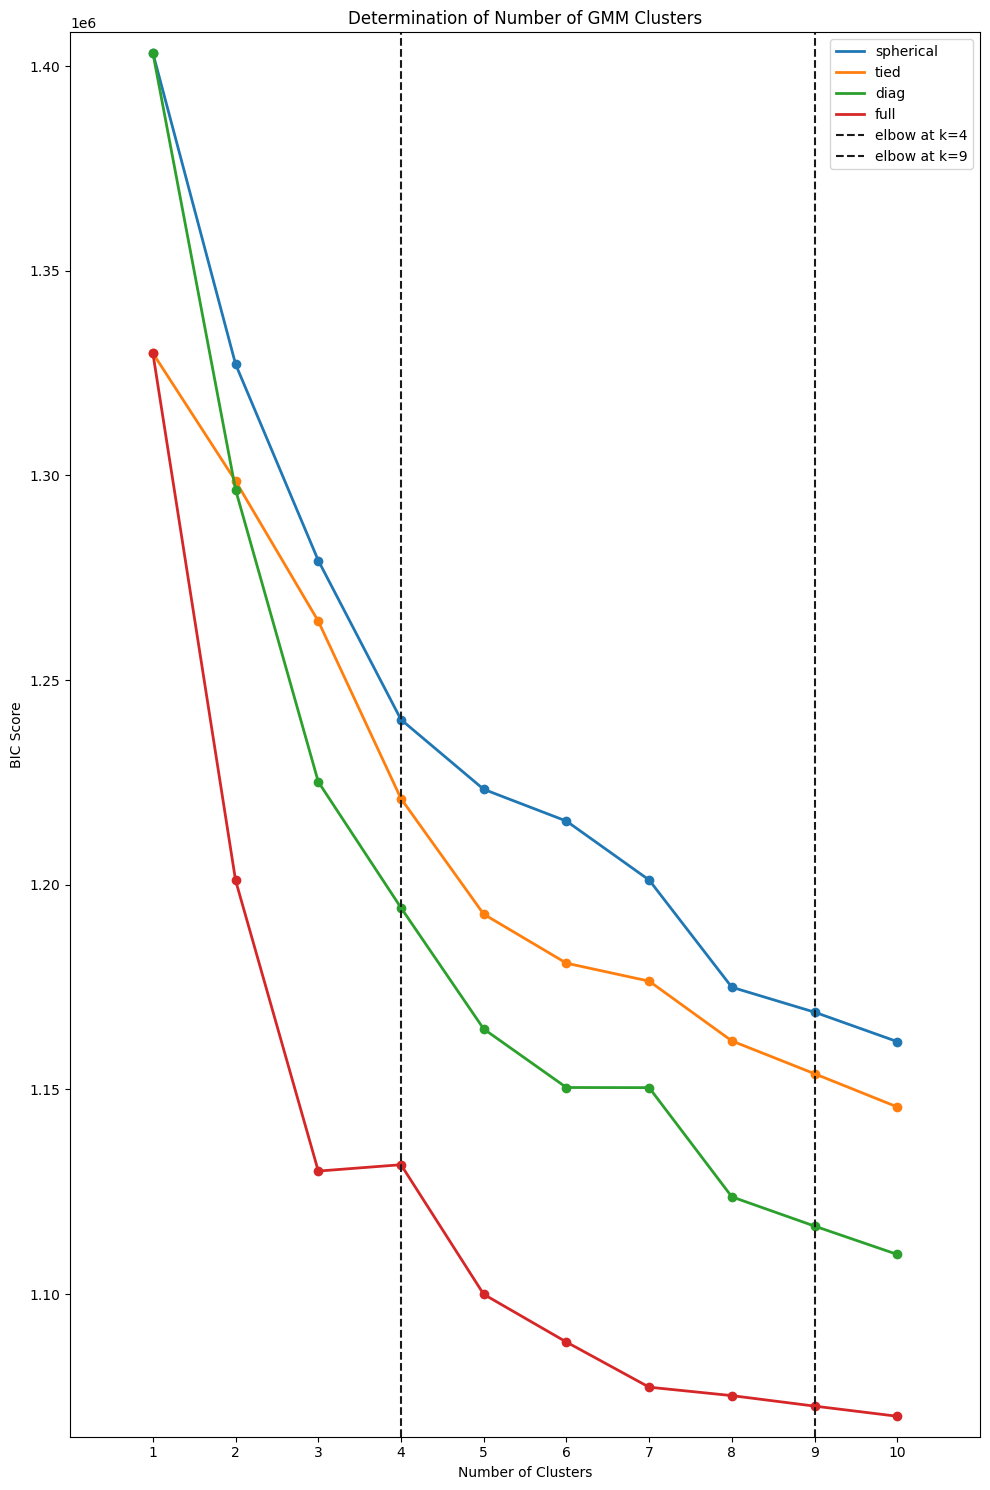

In [51]:
# Plot BIC 'spherical', 'tied', 'diag', 'full'
fig, ax_s = plt.subplots(1, figsize=(10,15), facecolor='w')

plt.plot(range(1,max_clusters+1), scoreg4[0,:]-(scoreg4.min()-scoreg4.min()), 'o-', c='C0', linewidth=2, label='spherical')
plt.plot(range(1,max_clusters+1), scoreg4[1,:]-(scoreg4.min()-scoreg4.min()), 'o-', c='C1', linewidth=2, label='tied')
plt.plot(range(1,max_clusters+1), scoreg4[2,:]-(scoreg4.min()-scoreg4.min()), 'o-', c='C2', linewidth=2, label='diag')
plt.plot(range(1,max_clusters+1), scoreg4[3,:]-(scoreg4.min()-scoreg4.min()), 'o-', c='C3', linewidth=2, label='full')

plt.vlines(4, scoreg4.min()-5000,scoreg4.max()+5000, colors='k', linestyles='dashed', label='elbow at k=4')
plt.vlines(9, scoreg4.min()-5000,scoreg4.max()+5000, colors='k', linestyles='dashed', label='elbow at k=9')
plt.legend(loc='upper right', markerscale=0)
ax_s.set_title('Determination of Number of GMM Clusters')
ax_s.set_xlabel('Number of Clusters')
ax_s.set_ylabel('BIC Score')
ax_s.set_ylim([scoreg4.min()-5000,scoreg4.max()+5000])
ax_s.set_xlim([0,max_clusters+1])
ax_s.set_xticks(range(1,max_clusters+1))

fig.tight_layout()
plt.savefig(results+"BIC", bbox_inches='tight')
plt.show()

In [52]:
# # Scree Plot
# pcas = [pca4, pca5, pca6, pca7]
# bands = ['4 band', '5 band', '6 band', '7 band']
# # for j in range(4):
# #     PC_values[j] = np.arange(pcas[j].n_components_) + 1
# PC_values4 = np.arange(pcas[0].n_components_) + 1
# PC_values5 = np.arange(pcas[1].n_components_) + 1
# PC_values6 = np.arange(pcas[2].n_components_) + 1
# PC_values7 = np.arange(pcas[3].n_components_) + 1
# PC_values = [PC_values4, PC_values5, PC_values6, PC_values7]
# fig5, ax_s = plt.subplots(1, facecolor='w')

# for i in range(4):
#     plt.plot(PC_values[i], pcas[i].explained_variance_ratio_.cumsum()*100, 'o-', linewidth=2, label=bands[i])
#     plt.bar(PC_values[i], pcas[i].explained_variance_ratio_*100)

# plt.hlines(95, 0, 7, colors='k', linestyles='dashed', label='95%')
# plt.legend(loc='center right')
# ax_s.set_title('Scree Plot')
# ax_s.set_xlabel('Number of Principal Components')
# ax_s.set_ylabel('Percentage Explained Variance')
# ax_s.set_ylim([0,100])
# ax_s.set_xlim([0,7])
# ax_s.set_xticks(PC_values7)

# fig.tight_layout()
# plt.show()

In [54]:
!zip -r /content/Results_6_25_24.zip /content/Results_6_25_24

  adding: content/Results_6_25_24/ (stored 0%)
  adding: content/Results_6_25_24/input_bands.png (deflated 1%)
  adding: content/Results_6_25_24/PCA_ICA_maps_components.png (deflated 1%)
  adding: content/Results_6_25_24/kde_iron_4band_k6_fan.png (deflated 5%)
  adding: content/Results_6_25_24/BIC.png (deflated 8%)
  adding: content/Results_6_25_24/Point_clouds_clustered.png (deflated 1%)
  adding: content/Results_6_25_24/maps.png (deflated 4%)
  adding: content/Results_6_25_24/kde_ti_4band_k6_fan.png (deflated 6%)
  adding: content/Results_6_25_24/BIC_AIC.png (deflated 13%)
  adding: content/Results_6_25_24/Pie_charts.png (deflated 3%)
  adding: content/Results_6_25_24/kde_carb_4band_k6_fan.png (deflated 4%)
  adding: content/Results_6_25_24/4band_fan_iron_clay_carb_ti_pk6.tif (deflated 99%)
  adding: content/Results_6_25_24/ICA_components.png (deflated 19%)
  adding: content/Results_6_25_24/kde_clay_4band_k6_fan.png (deflated 5%)
  adding: content/Results_6_25_24/Inertia.png (deflate

# Supplemental: Central swath dataset above road

In [59]:
# Lists all .tif files in your Google Drive folder
import os
def myfunction(data):
  print(data)

path2 = 'drive/MyDrive/Cucomungo_Datasets_Colab/central_swath_above_road_datasets/'

for file in os.listdir(path2):
  if file.endswith(".tif"):
    myfunction(file)

iron_road.tif
clay_road.tif
carb_road.tif
ti_road.tif
ndvi_road.tif
rough_road.tif
detrend_road.tif


In [62]:
# Open raster files full fan
iron_road = rasterio.open(path2+'iron_road.tif');
clay_road = rasterio.open(path2+'clay_road.tif');
carb_road = rasterio.open(path2+'carb_road.tif');
ti_road = rasterio.open(path2+'ti_road.tif');
rough_road = rasterio.open(path2+'rough_road.tif');
detrend_road = rasterio.open(path2+'detrend_road.tif');

# Create arrays
iron_road_arr = iron_road.read([1]);
clay_road_arr = clay_road.read([1]);
carb_road_arr = carb_road.read([1]);
ti_road_arr = ti_road.read([1]);
rough_road_arr = rough_road.read([1]);
detrend_road_arr = detrend_road.read([1]);

# Combine bands into one dataset
combined_road = np.concatenate([iron_road_arr,
                           clay_road_arr,
                           carb_road_arr,
                           ti_road_arr,
                           rough_road_arr,
                           detrend_road_arr]);
combined_road = np.moveaxis(combined_road, 0, 2);

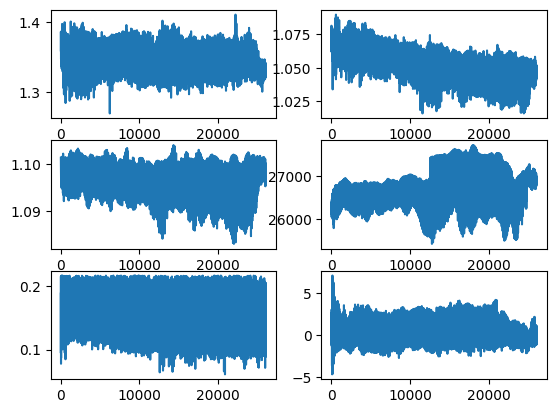

In [81]:
# Create datasets road and flatten
data6b_road = combined_road[...,[0,1,2,3,4,5]];
data6bf_road = np.reshape(data6b_road, [data6b_road.shape[0]*data6b_road.shape[1], data6b_road.shape[2]]);

# Get list of good data indices, helps to view histograms in QGIS
data_inds6_road = list(set(np.where((data6bf_road[...,5] > -8) & (data6bf_road[...,5] < 8) & (data6bf_road[...,4] < 0.3) & (data6bf_road[...,4] > 0.05) & (data6bf_road[...,2] < 1.11) & (data6bf_road[...,2] > 1.08))[0]));

fig, a = plt.subplots(3, 2)
a[0][0].plot(data6bf_road[data_inds6_road,0])
a[0][1].plot(data6bf_road[data_inds6_road,1])
a[1][0].plot(data6bf_road[data_inds6_road,2])
a[1][1].plot(data6bf_road[data_inds6_road,3])
a[2][0].plot(data6bf_road[data_inds6_road,4])
a[2][1].plot(data6bf_road[data_inds6_road,5])
plt.show()

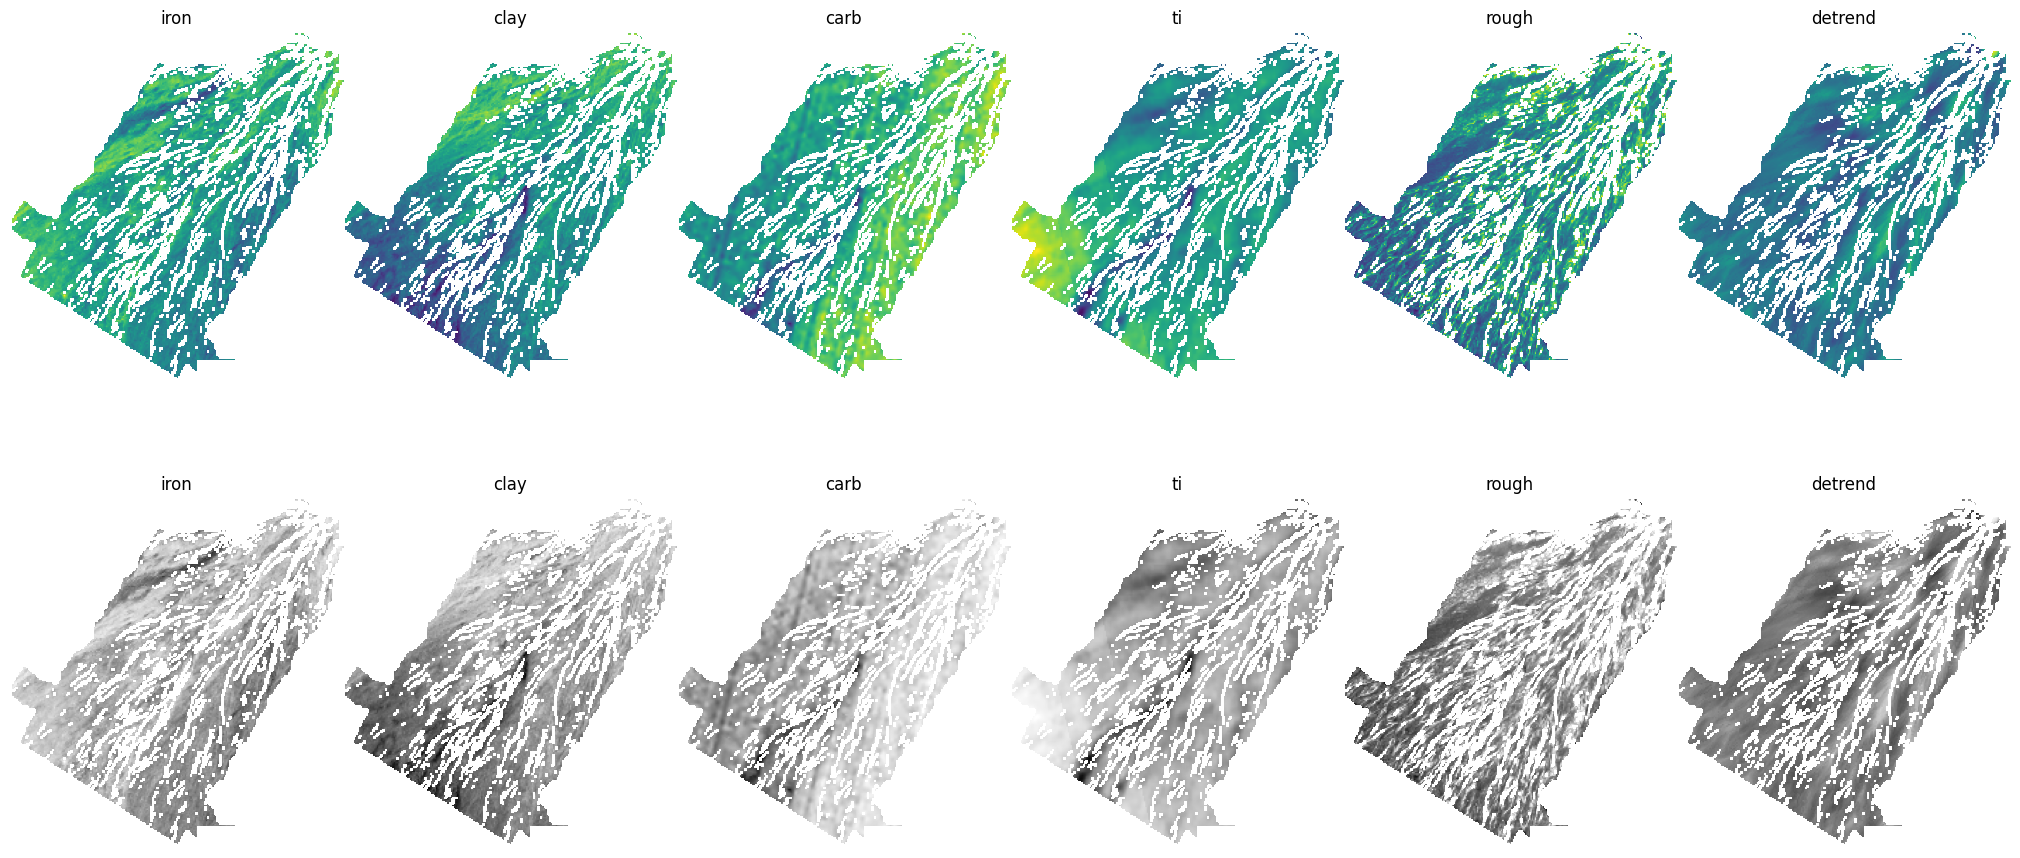

In [86]:
# Clean data by removing negative values and assigning no data to -1
# Create flattened array of no_data as -1
cleaned_roadf = np.full(data6bf_road.shape, -1, dtype='float32');

# Add good data to the array
for i,val in enumerate(data_inds6_road):
    cleaned_roadf[val,:] = data6bf_road[val,:]

# Reshape cluster map from flattened to original raster
cleaned_road = np.reshape(cleaned_roadf, [combined_road.shape[0], combined_road.shape[1], combined_road.shape[2]]);

#assign -1.0 to nan
cleaned_road[cleaned_road == -1.0] = np.nan

img1 = cleaned_road[:,:,0]
img2 = cleaned_road[:,:,1]
img3 = cleaned_road[:,:,2]
img4 = cleaned_road[:,:,3]
img5 = cleaned_road[:,:,4]
img6 = cleaned_road[:,:,5]

names = ["iron", "clay", "carb", "ti", "rough", "detrend"]
fig, ax = plt.subplots(2, 6, figsize=(20, 15), facecolor='w')
ax[0,0].imshow(img1, cmap='viridis')
ax[0,1].imshow(img2, cmap='viridis')
ax[0,2].imshow(img3, cmap='viridis')
ax[0,3].imshow(img4, cmap='viridis')
ax[0,4].imshow(img5, cmap='viridis')
ax[0,5].imshow(img6, cmap='viridis')
ax[1,0].imshow(img1, cmap='Greys_r')
ax[1,1].imshow(img2, cmap='Greys_r')
ax[1,2].imshow(img3, cmap='Greys_r')
ax[1,3].imshow(img4, cmap='Greys_r')
ax[1,4].imshow(img5, cmap='Greys_r')
ax[1,5].imshow(img6, cmap='Greys_r')

for i in range(6):
    ax[0,i].set_title(names[i])
    ax[1,i].set_title(names[i])

for a in ax.ravel():
    a.set_axis_off()
plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0, hspace=-0.55)
plt.savefig(results+"road_input_bands.png")
plt.show()

In [90]:
# Normalize bands
scaler6_road = StandardScaler().fit(data6bf_road[data_inds6_road]);
data6bf_road_norm = scaler6_road.transform(data6bf_road[data_inds6_road]);

# Run PCA Raod
pk = 5;
pca6road = PCA(n_components=pk, random_state=5);
data_pca6road = pca6road.fit_transform(data6bf_road_norm);

# Create flattened null array of no_data as 0
back_pca6road = np.full((data6bf_road.shape[0],5), 0, dtype='float');

# Add PCA values to flattened array
for i in range(data_pca6road.shape[0]):
    for b in range(data_pca6road.shape[1]):
        back_pca6road[data_inds6_road[i],b] = data_pca6road[i,b]

# Reshape PCA to raster map
map_pca6road = np.reshape(back_pca6road, [data6b_road.shape[0], data6b_road.shape[1], data_pca6road.shape[1]]);

# Run k-means++ after running PCA on normalized data
k = 4;
kmeansp4road = KMeans(n_clusters=k, random_state=5);
kmeansp4road.fit(data_pca6road);
k = 5;
kmeansp5road = KMeans(n_clusters=k, random_state=5);
kmeansp5road.fit(data_pca6road);
k = 6;
kmeansp6road = KMeans(n_clusters=k, random_state=5);
kmeansp6road.fit(data_pca6road);
k = 7;
kmeansp7road = KMeans(n_clusters=k, random_state=5);
kmeansp7road.fit(data_pca6road);
# Create flattened array of no_data as -1
clustered_pca4road = np.full(data6bf_road.shape[0], -1, dtype='int32');
clustered_pca5road = np.full(data6bf_road.shape[0], -1, dtype='int32');
clustered_pca6road = np.full(data6bf_road.shape[0], -1, dtype='int32');
clustered_pca7road = np.full(data6bf_road.shape[0], -1, dtype='int32');
# Add cluster labels to flattened data
for i in range(kmeansp4road.labels_.shape[0]):
    clustered_pca4road[data_inds6_road[i]] = kmeansp4road.labels_[i]
for i in range(kmeansp5road.labels_.shape[0]):
    clustered_pca5road[data_inds6_road[i]] = kmeansp5road.labels_[i]
for i in range(kmeansp6road.labels_.shape[0]):
    clustered_pca6road[data_inds6_road[i]] = kmeansp6road.labels_[i]
for i in range(kmeansp7road.labels_.shape[0]):
    clustered_pca7road[data_inds6_road[i]] = kmeansp7road.labels_[i]
# Reshape cluster map to raster
clusteredp4road = np.reshape(clustered_pca4road, [data6b_road.shape[0], data6b_road.shape[1]]);
clusteredp5road = np.reshape(clustered_pca5road, [data6b_road.shape[0], data6b_road.shape[1]]);
clusteredp6road = np.reshape(clustered_pca6road, [data6b_road.shape[0], data6b_road.shape[1]]);
clusteredp7road = np.reshape(clustered_pca7road, [data6b_road.shape[0], data6b_road.shape[1]]);

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


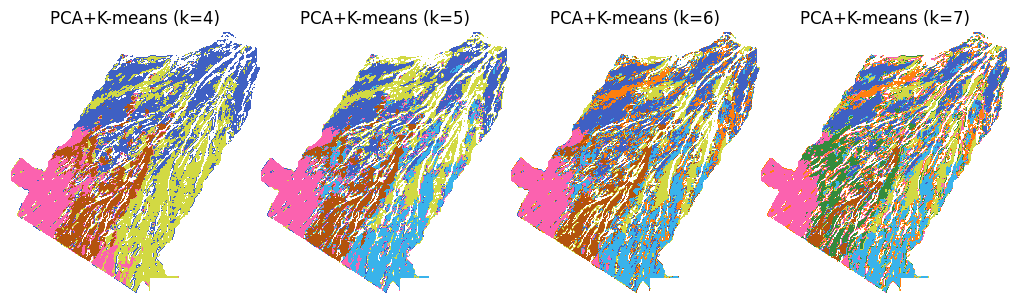

In [104]:
# Create color maps manually for consistency as assigned cluster numbers shift randomly
cmapk4 = mpl.colors.ListedColormap([none, blue, gold, pink, brown])
cmapk5 = mpl.colors.ListedColormap([none, gold, blue, pink, lightblue, brown])
cmapk6 = mpl.colors.ListedColormap([none, gold, brown, lightblue, blue, orange, pink])
cmapk7 = mpl.colors.ListedColormap([none, orange, pink, green, gold, lightblue, blue, brown])

# Maps Plot above road
cmapjk = [cmapk4,cmapk5,cmapk6,cmapk7]
clusteredpgroad = np.array([clusteredp4road, clusteredp5road, clusteredp6road, clusteredp7road])
titlesjk = ['PCA+K-means (k=4)','PCA+K-means (k=5)','PCA+K-means (k=6)','PCA+K-means (k=7)']

fig, ax = plt.subplots(1, 4, figsize=(10, 20), facecolor='w')
for j in range(4):
    ax[j].imshow(clusteredpgroad[j], cmap=cmapjk[j])
    ax[j].axis('off')
    ax[j].set_title(titlesjk[j])

plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0, hspace=-.2)
plt.savefig(results+"above_road_maps.png", bbox_inches='tight')